**Crime Rate prediction Per Neighbourhood applying Linear Regression, Decision Tree and Random Forest Regression models and picking the best score based on minimum error.**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from tqdm import tqdm
import datetime
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20, 20)
plt.rcParams['font.size'] = 14

**Data Ingestion**

In [ ]:
crime_df = pd.read_excel('/output.xlsx')
crime_df

Unnamed: 0          X          Y  OBJECTID EVENT_UNIQUE_ID  \
0                0 -79.375662  43.656815    134022     GO-20181532   
1                1 -79.334607  43.755305    134023     GO-20184352   
2                2 -79.419960  43.687202    134024     GO-20184878   
3                3 -79.409444  43.674206    134025     GO-20183609   
4                4 -79.237136  43.721021    134026     GO-20184674   
...            ...        ...        ...       ...             ...   
177618      187331 -79.301740  43.736102    323292  GO-20222554300   
177619      187332 -79.258639  43.828794    323293  GO-20222557893   
177620      187333 -79.425645  43.701404    323294  GO-20222559486   
177621      187334 -79.385170  43.672134    323295  GO-20222557956   
177622      187335 -79.248081  43.736690    323296  GO-20222558010   

                 REPORT_DAT   OCC_DATE  REPORT_YEAR REPORT_MONTH  REPORT_DAY  \
0                2018-01-01 2018-01-01         2018      January           1   
1                2018-01-01 2018-01-01         2018      January           1   
2                2018-01-01 2018-01-01         2018      January           1   
3                2018-01-01 2018-01-01         2018      January           1   
4       2018-01-01 00:00:00 2018-01-01         2018      January           1   
...                     ...        ...          ...          ...         ...   
177618           2022-12-31 2022-12-22         2022     December          31   
177619           2022-12-31 2022-12-31         2022     December          31   
177620           2022-12-31 2022-12-22         2022     December          31   
177621           2022-12-31 2022-12-31         2022     December          31   
177622           2022-12-31 2022-12-31         2022     December          31   

        ...    NEIGHBOURHOOD_158 HOOD_140      NEIGHBOURHOOD_140     Division  \
0       ...  Downtown Yonge East       75  Church-Yonge Corridor  51 Division   
1       ...    Fenside-Parkwoods       45      Parkwoods-Donalda  33 Division   
2       ...   Humewood-Cedarvale      106     Humewood-Cedarvale  13 Division   
3       ...                Annex       95                  Annex  14 Division   
4       ...           Cliffcrest      123             Cliffcrest  43 Division   
...     ...                  ...      ...                    ...          ...   
177618  ...     Wexford/Maryvale      119       Wexford/Maryvale  41 Division   
177619  ...             Milliken      130               Milliken  42 Division   
177620  ...    Forest Hill North      102      Forest Hill North  53 Division   
177621  ...  Rosedale-Moore Park       98    Rosedale-Moore Park  53 Division   
177622  ...        Eglinton East      138          Eglinton East  43 Division   

       Count_of_police_force          Neighbourhood  \
0                 285.000000  Church-Yonge Corridor   
1                 152.000000      Parkwoods-Donalda   
2                 185.000000     Humewood-Cedarvale   
3                 275.000000                  Annex   
4                 258.000000             Cliffcrest   
...                      ...                    ...   
177618            239.381817       Wexford/Maryvale   
177619            239.381817               Milliken   
177620            239.381817      Forest Hill North   
177621            239.381817    Rosedale-Moore Park   
177622            239.381817          Eglinton East   

        Average Individual Employment Income Population  Unemployment Rate  \
0                                      55168      31340                8.5   
1                                      43071      34805                9.2   
2                                      62707      14365                7.1   
3                                     102593      30526                6.7   
4                                      45539      15935                9.7   
...                                      ...        ...                ...   
177618                    

**Data Transformation**

In [ ]:
crime_df['REPORT_DAT'] = pd.to_datetime(crime_df['REPORT_DAT'])

In [ ]:
crime_df['Population'] = pd.to_numeric(crime_df['Population'])

In [ ]:
crime_df['Count_of_police_force'] = pd.to_numeric(crime_df['Count_of_police_force'])

In [ ]:
crime_df['Average Individual Employment Income'] = pd.to_numeric(crime_df['Average Individual Employment Income'])

In [ ]:
crime_df['Unemployment Rate'] = pd.to_numeric(crime_df['Unemployment Rate'])

In [ ]:
crime_df['Low Income population(LIM-AT)'] = pd.to_numeric(crime_df['Low Income population(LIM-AT)'])

In [ ]:
crime_df = crime_df[(crime_df['MCI_CATEGORY'] == 'Assault') & (crime_df['REPORT_YEAR'] >= 2018)]

**Grouping the data to get #crimes as 1 record per Neighbourhood per date**

In [ ]:
grouped_crimedf = crime_df.groupby(['REPORT_DAT', 'HOOD_140'], as_index=False).agg({
    'REPORT_DOW': 'first',
    'DIVISION': 'first',
    'LOCATION_TYPE': 'first',
    'PREMISES_TYPE': 'first',
    'OFFENCE': 'first',
    'Neighbourhood': 'first',
    'Count_of_police_force': 'first',
    'Average Individual Employment Income': 'first',
    'Population': 'first',
    'Unemployment Rate': 'first',
    'Low Income population(LIM-AT)': 'first',
    'EVENT_UNIQUE_ID': 'count'
})

In [ ]:
grouped_crimedf.rename(columns={'EVENT_UNIQUE_ID': 'Total_Event_Count'}, inplace=True)

Crime rate per 1000 population = (Total Crime count/population) * 100 **bold text**

In [ ]:
#crime rate:
grouped_crimedf['crime_rate_per_1000'] = (grouped_crimedf['Total_Event_Count']/(grouped_crimedf['Population'] )) * 1000

**Checking the outliers per Neighbourhood**

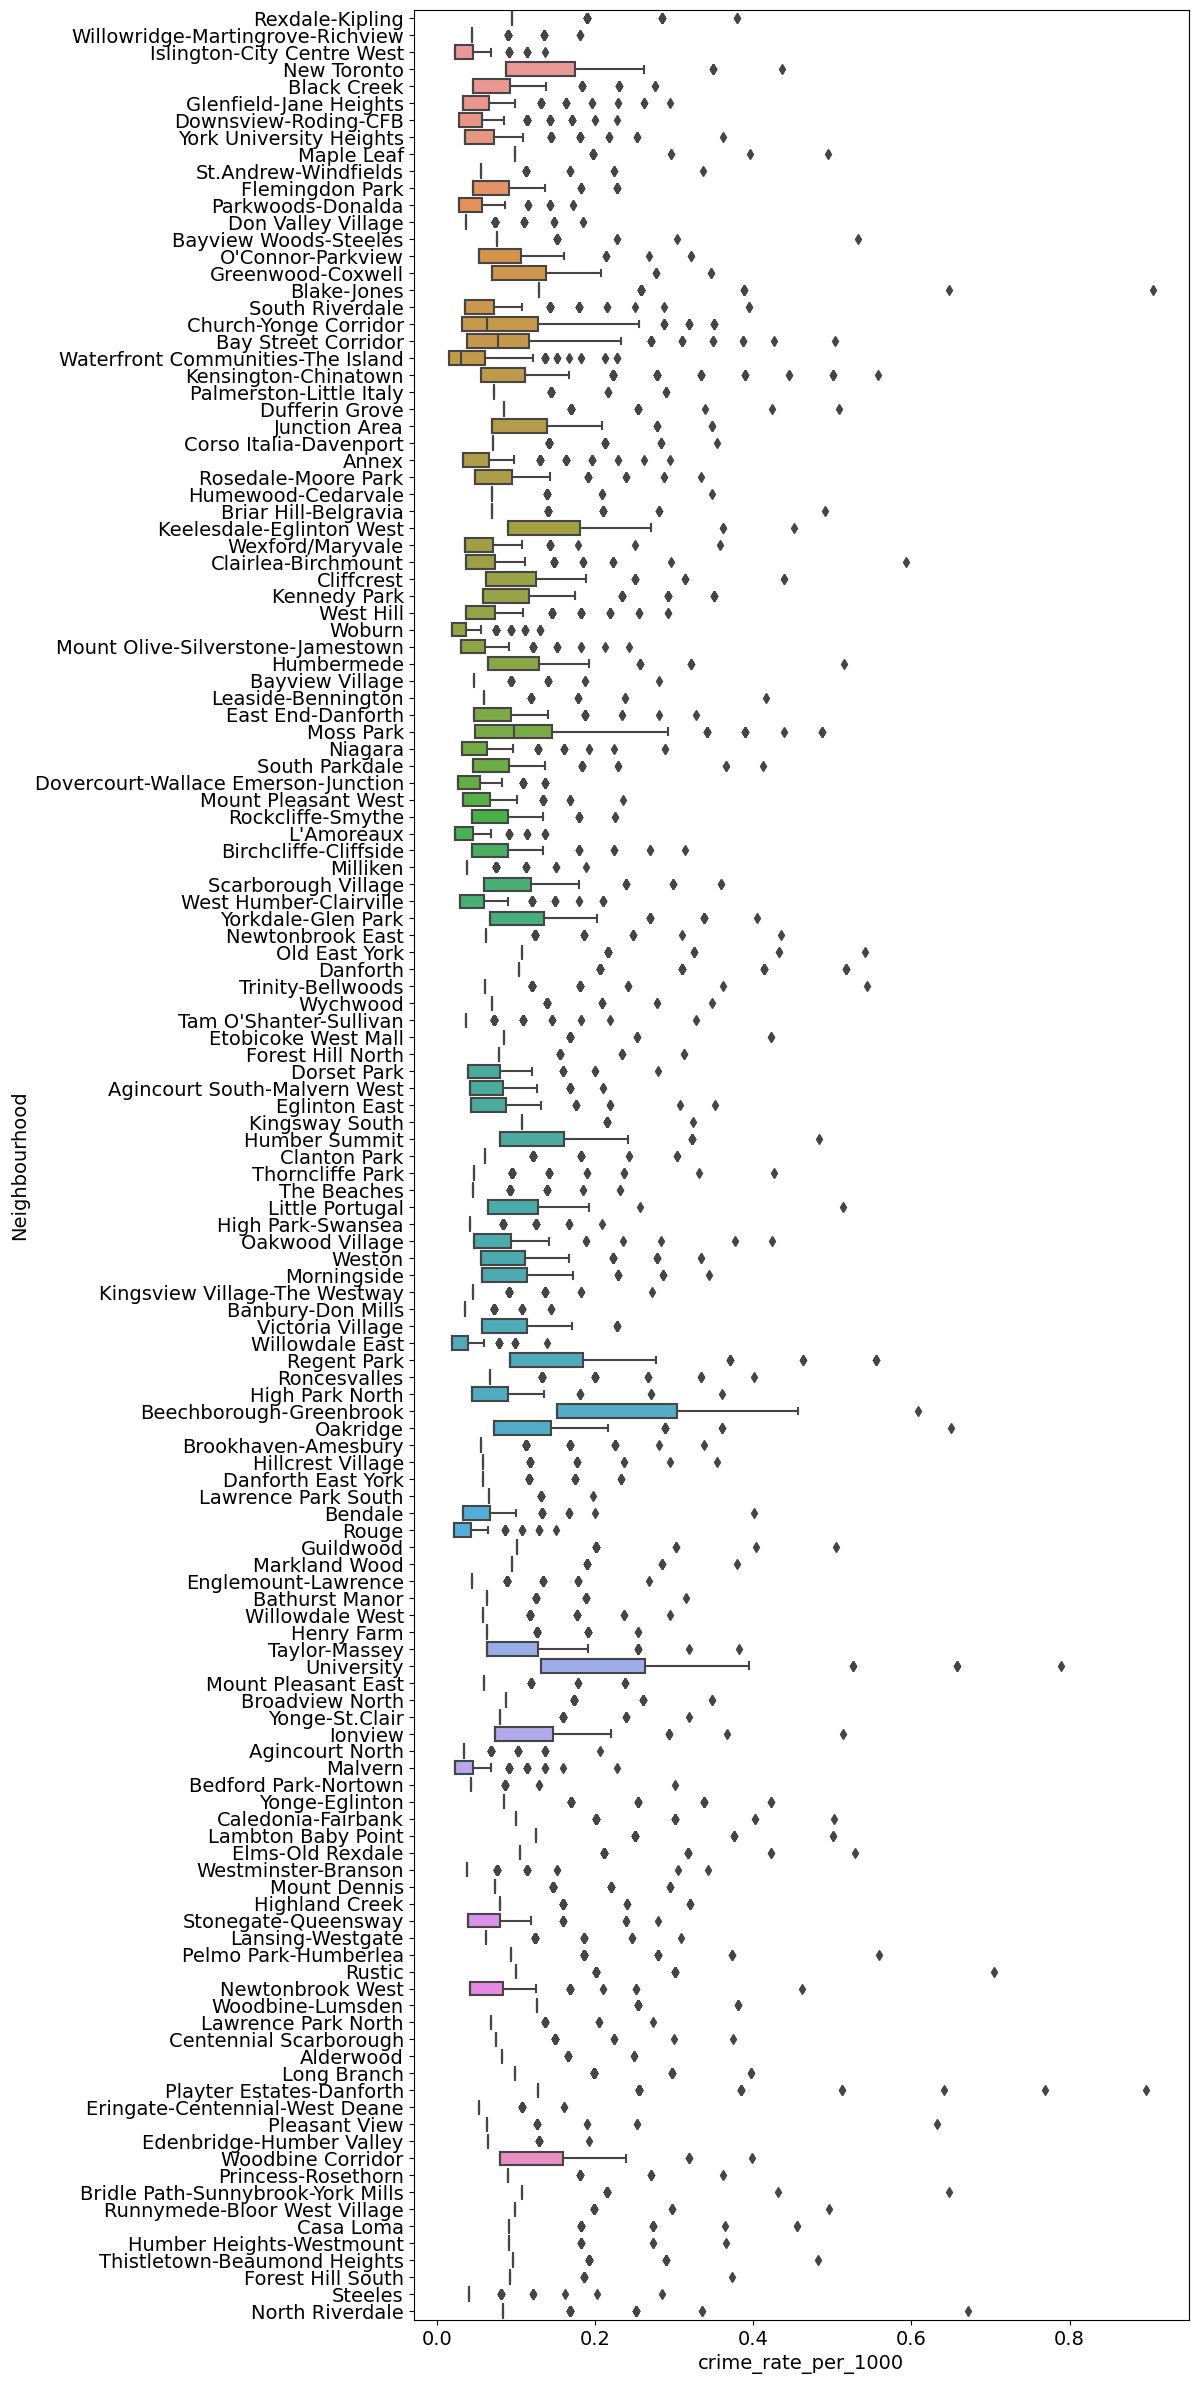

In [ ]:
#Box plot for outlier for crime rate
fig = plt.figure(figsize=(10,30))
sns.boxplot(x='crime_rate_per_1000', y='Neighbourhood', data=grouped_crimedf)
plt.savefig('crimeboxplot.png')

**Checking the distribution of crime rate and plotting on histogram all the values below 95 percentile**

In [ ]:

print(grouped_crimedf['crime_rate_per_1000'].describe())

print("95th percentile = " + str(grouped_crimedf.crime_rate_per_1000.quantile(0.95)))

count    59364.000000
mean         0.075985
std          0.053988
min          0.015172
25%          0.041797
50%          0.062123
75%          0.092734
max          0.905914
Name: crime_rate_per_1000, dtype: float64
95th percentile = 0.18086453246518358


<Axes: ylabel='Frequency'>

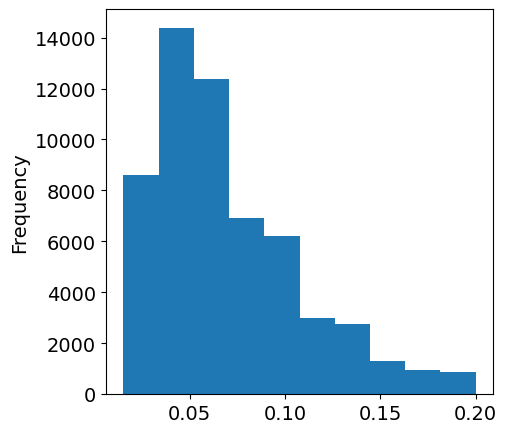

In [ ]:
fig = plt.figure(figsize=(5,5))
less_than_02 = grouped_crimedf['crime_rate_per_1000'] < 0.2
grouped_crimedf[less_than_02]['crime_rate_per_1000'].plot(kind='hist', bins=10)

**Checking the crime_rate_per_1000 rate trend for each Neighbourhood**

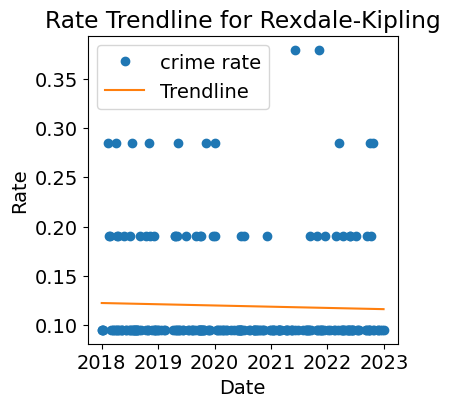

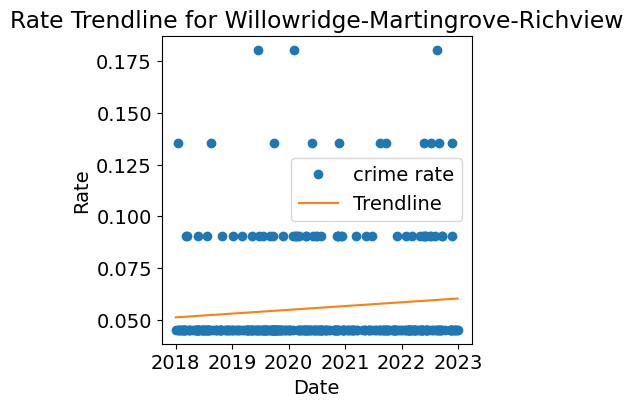

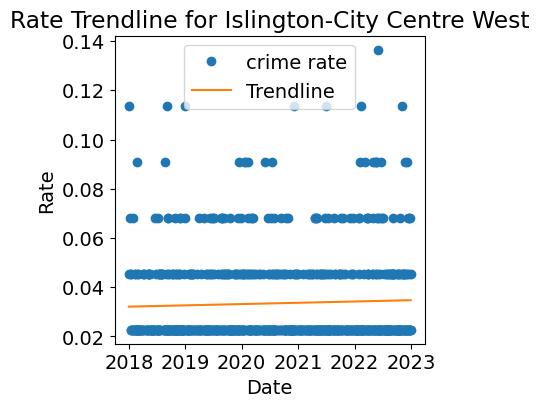

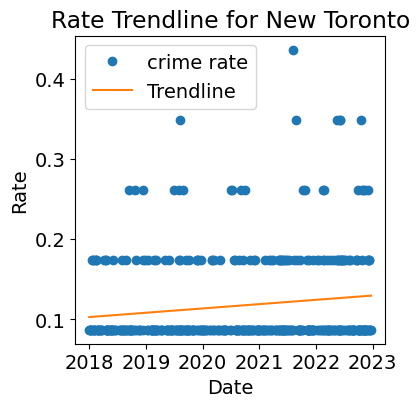

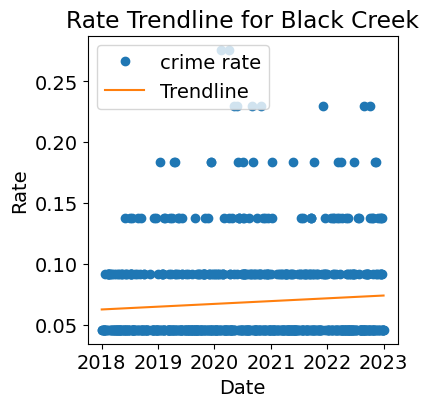

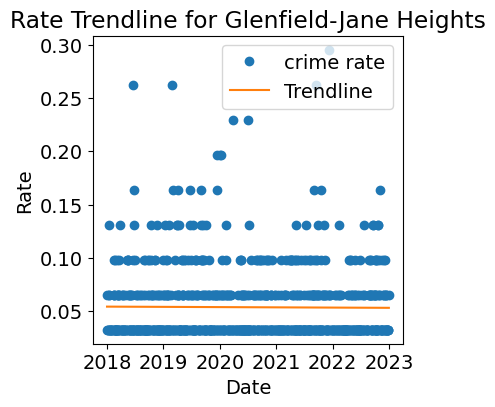

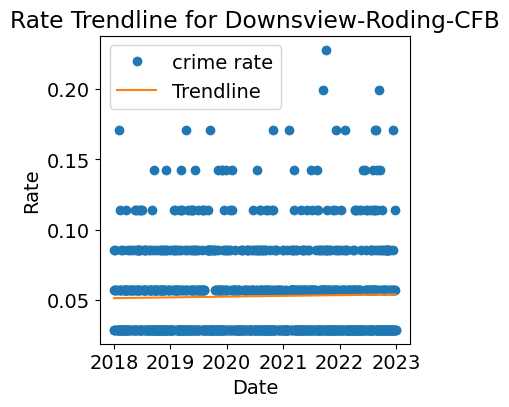

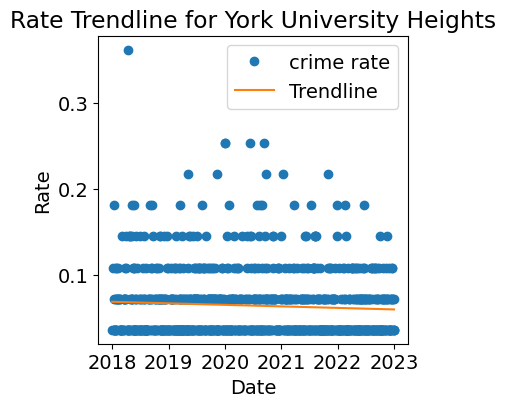

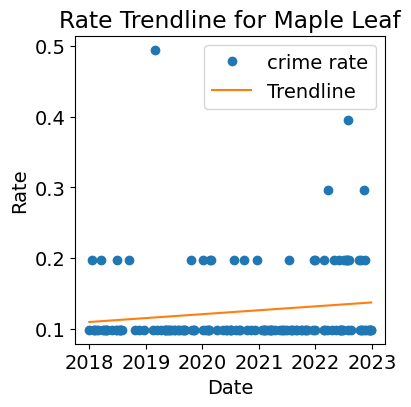

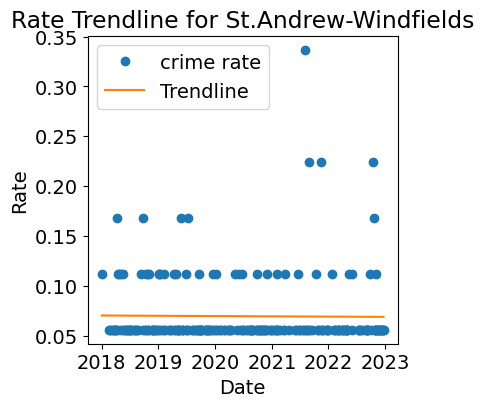

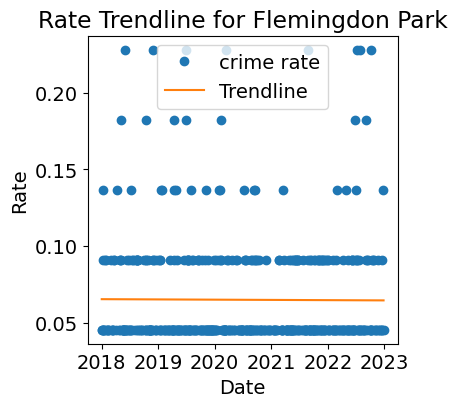

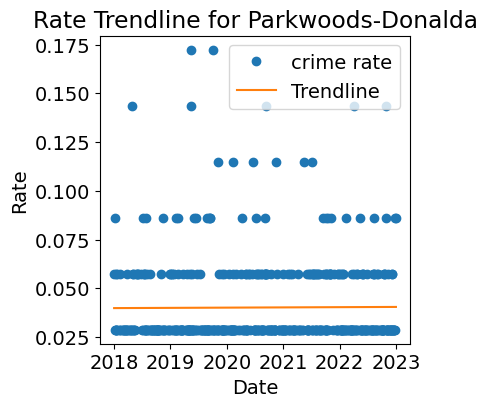

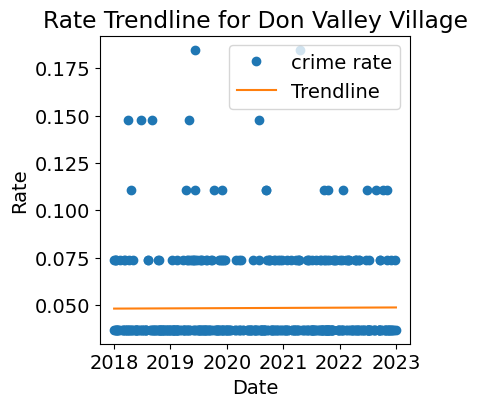

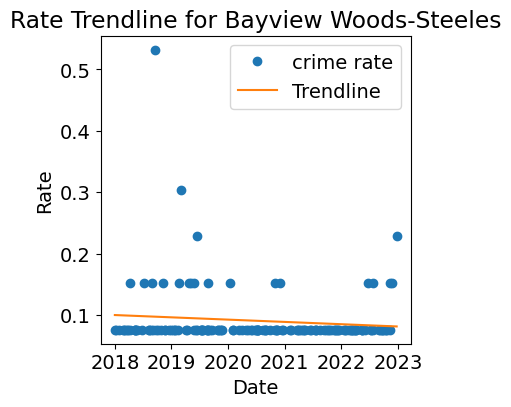

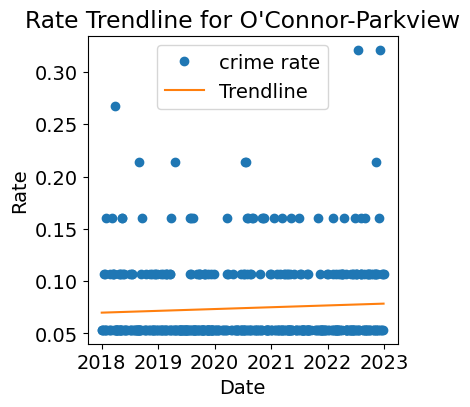

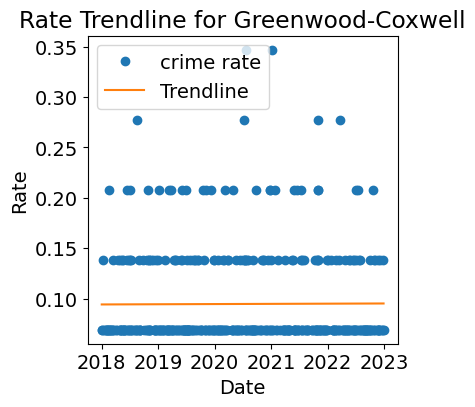

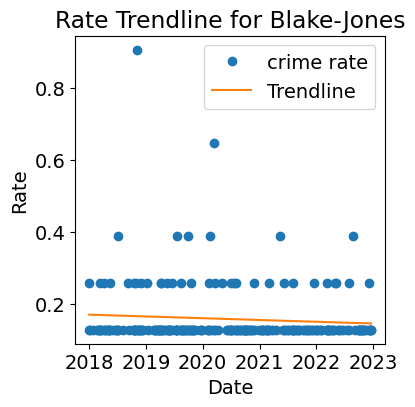

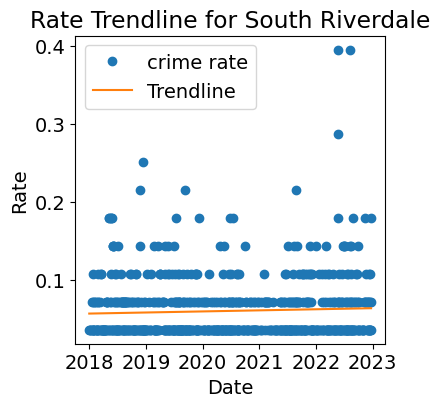

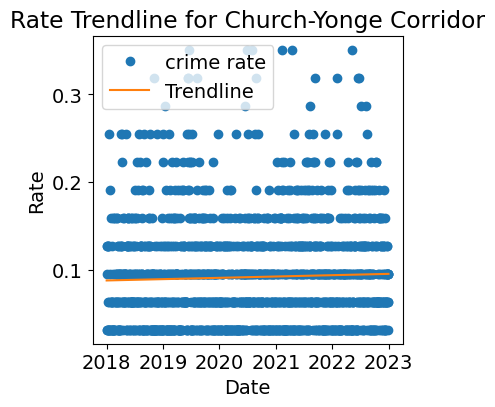

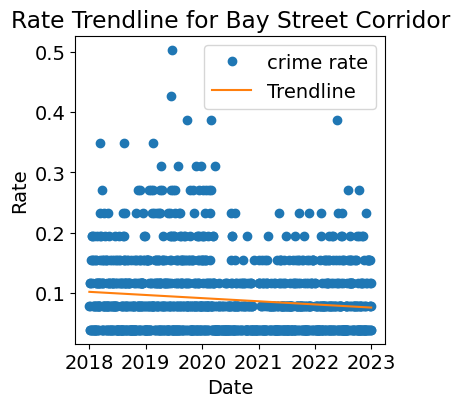

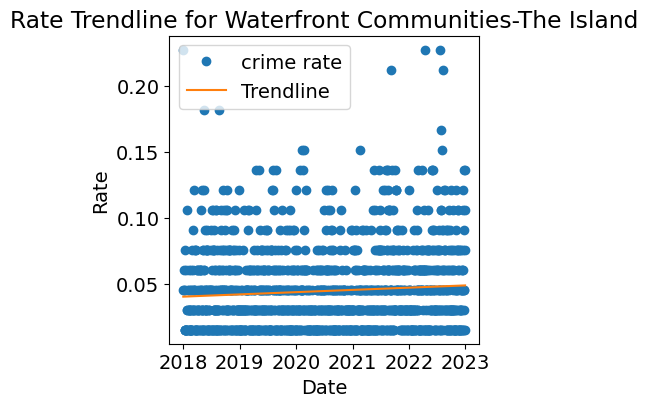

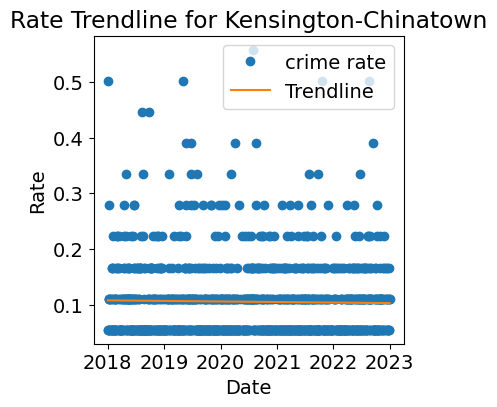

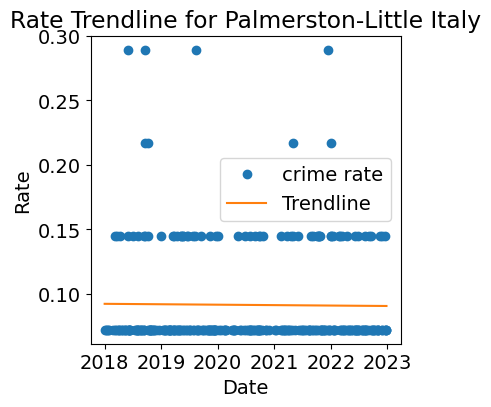

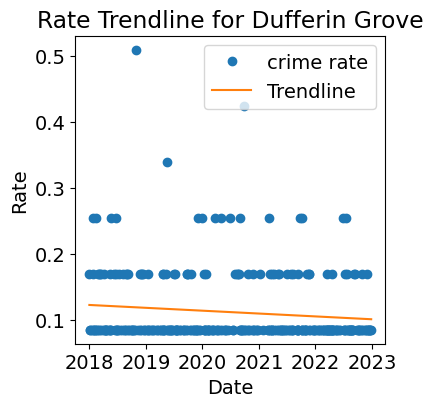

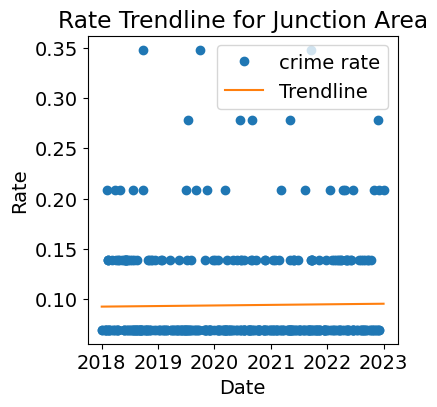

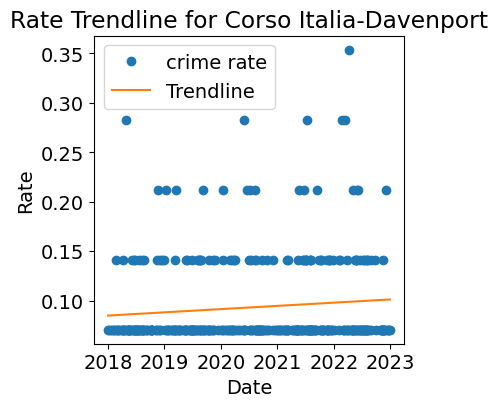

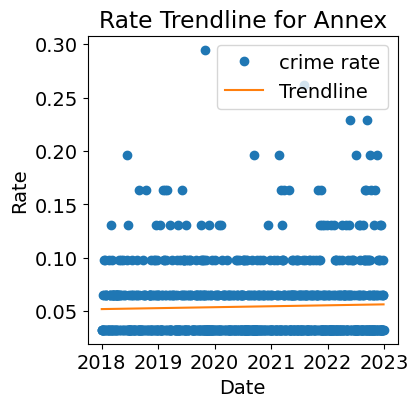

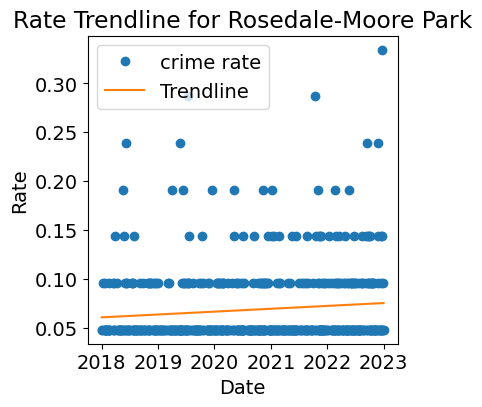

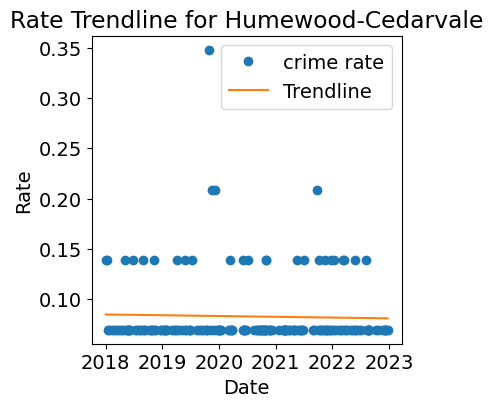

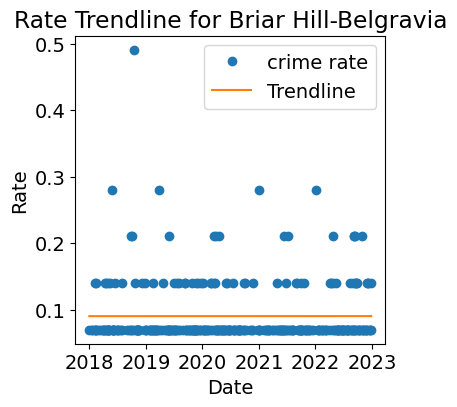

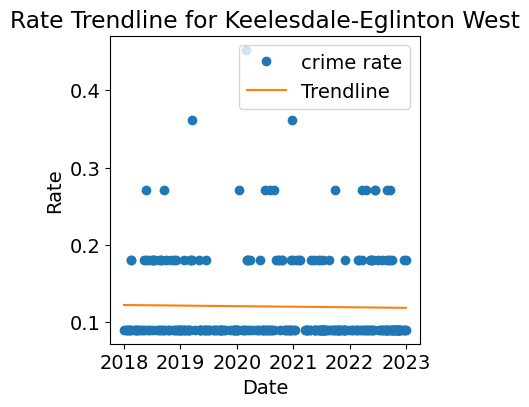

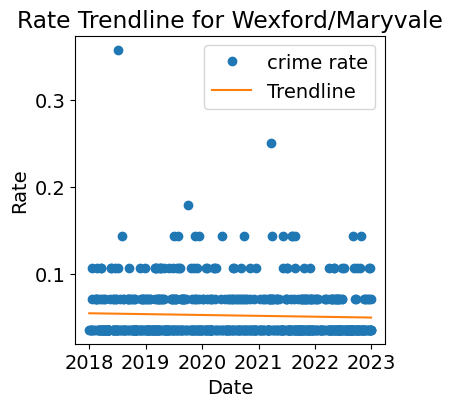

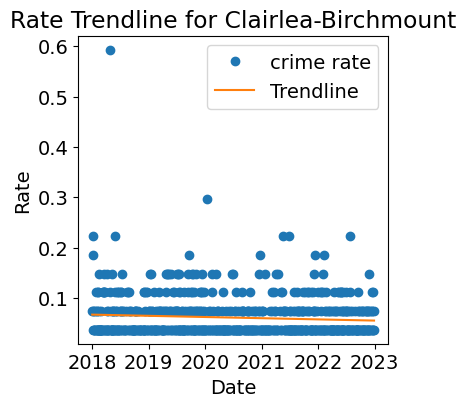

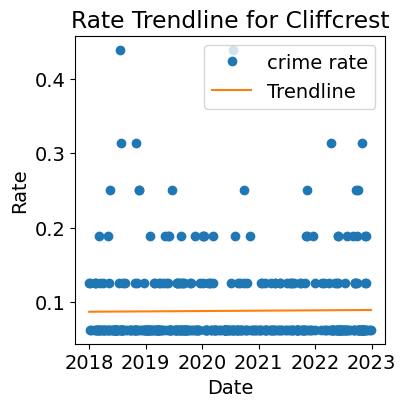

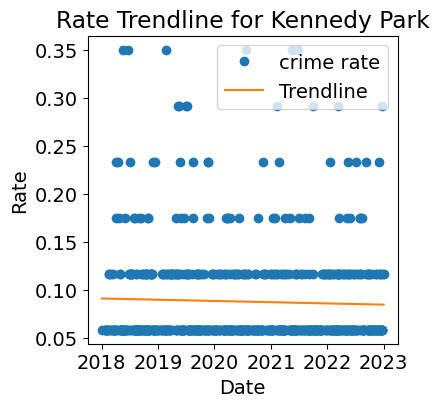

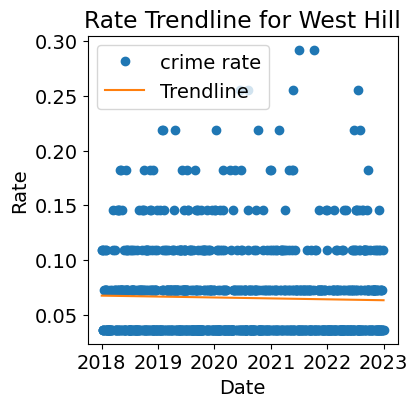

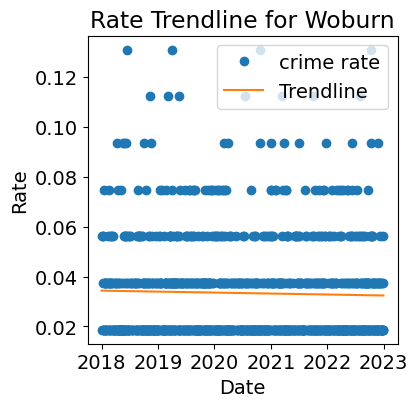

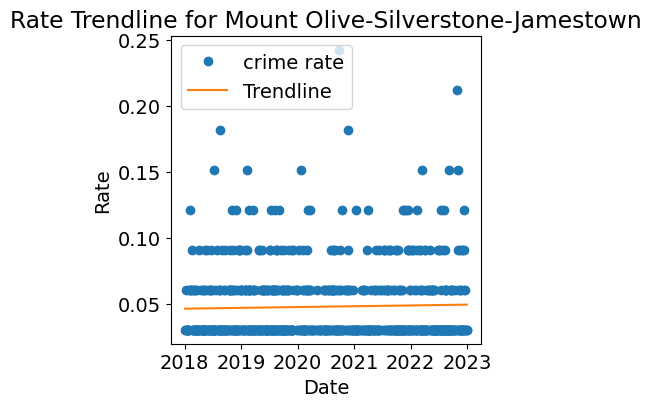

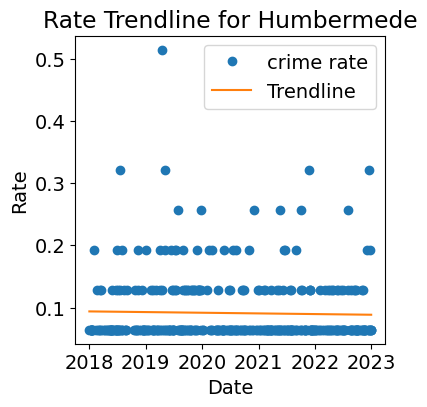

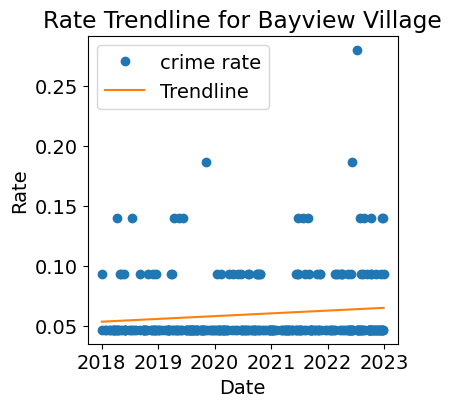

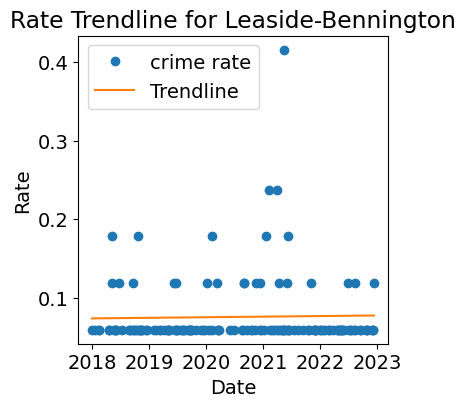

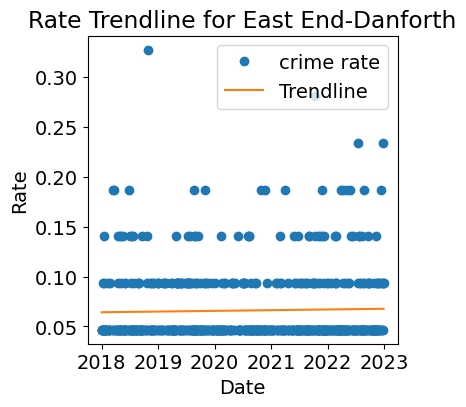

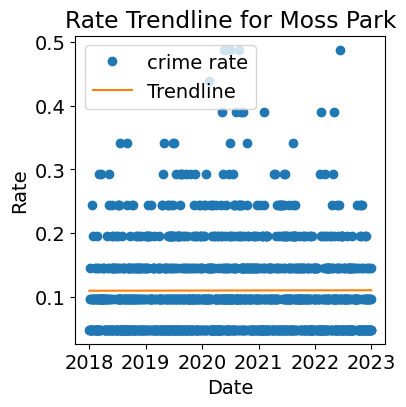

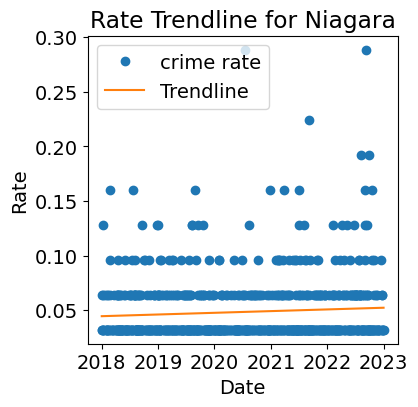

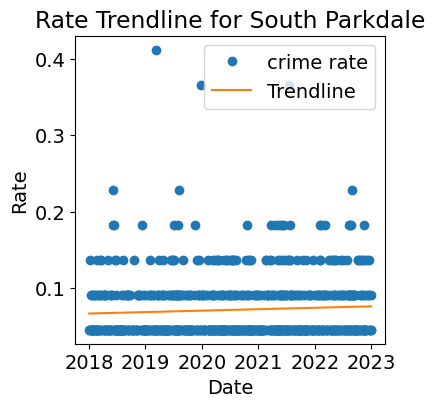

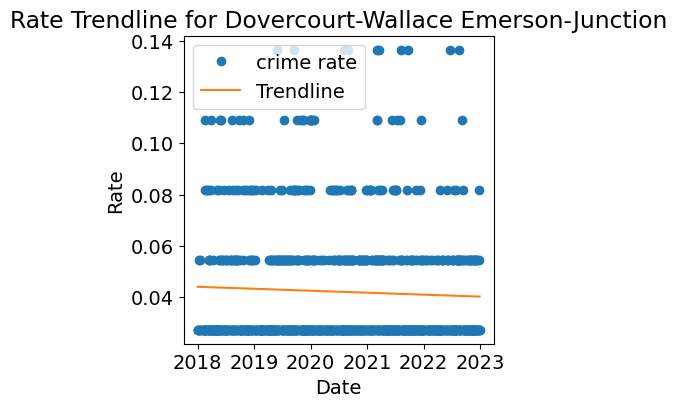

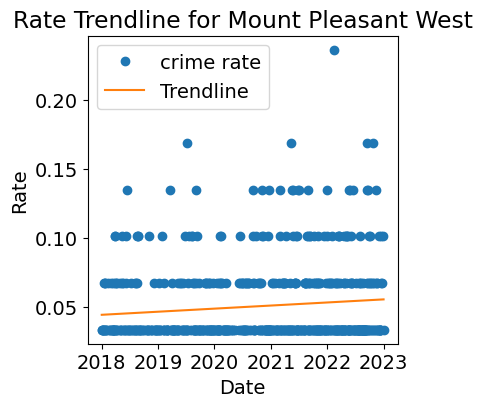

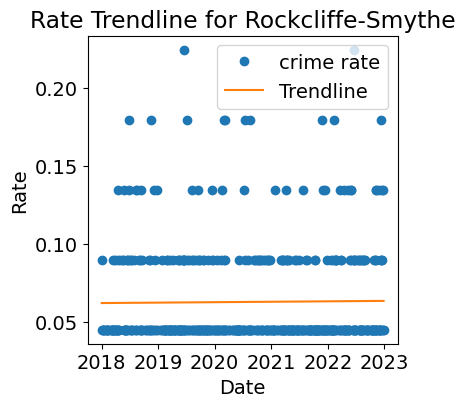

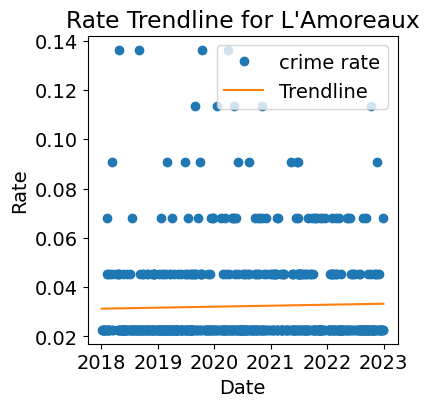

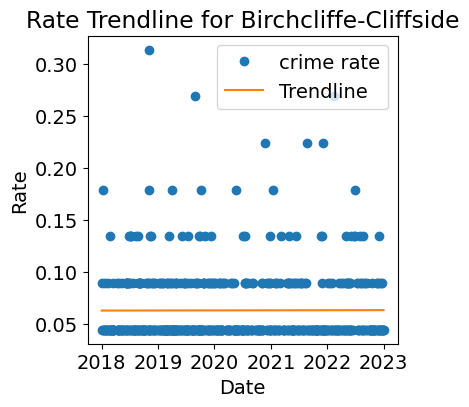

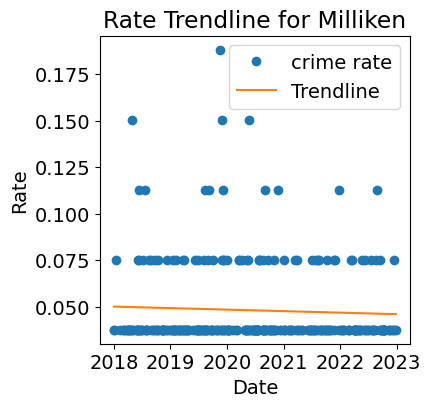

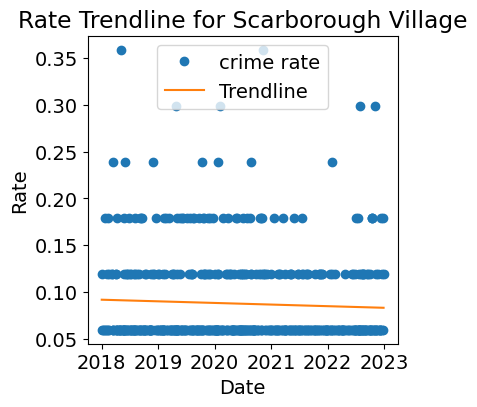

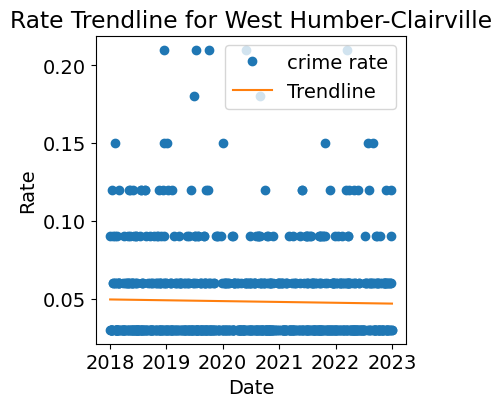

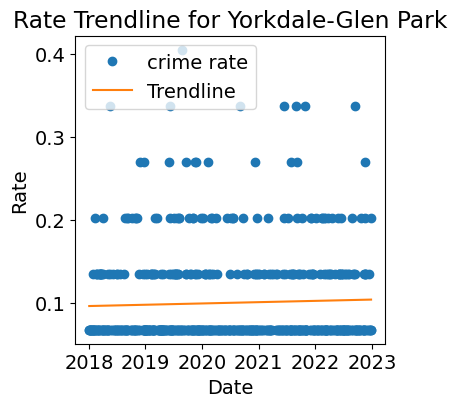

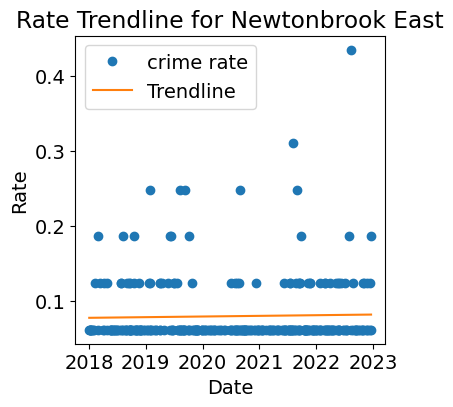

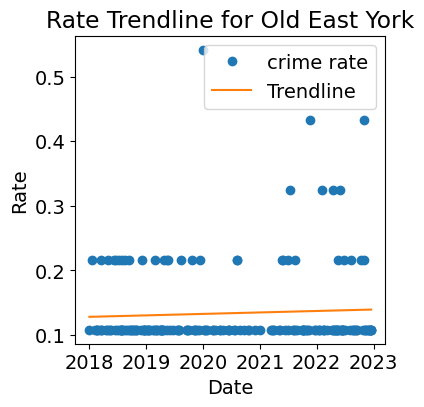

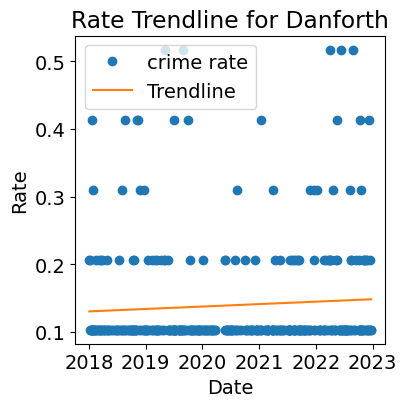

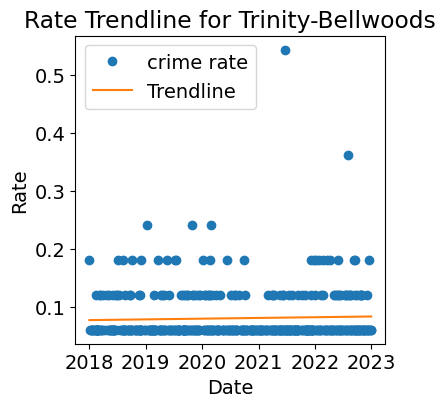

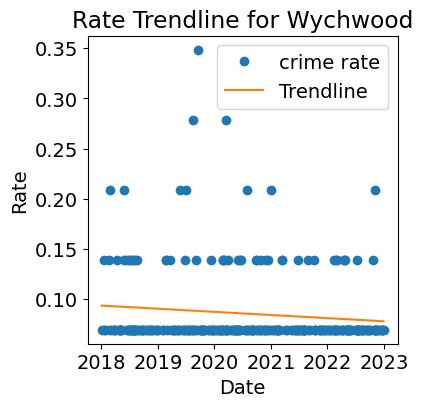

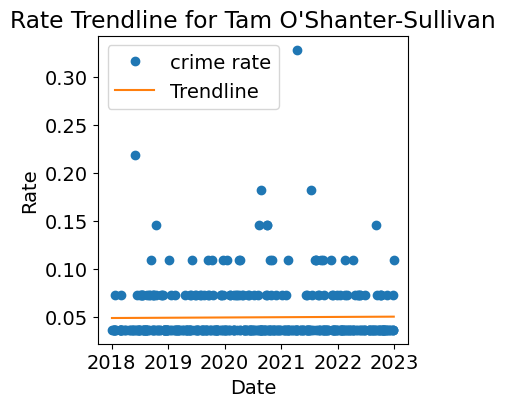

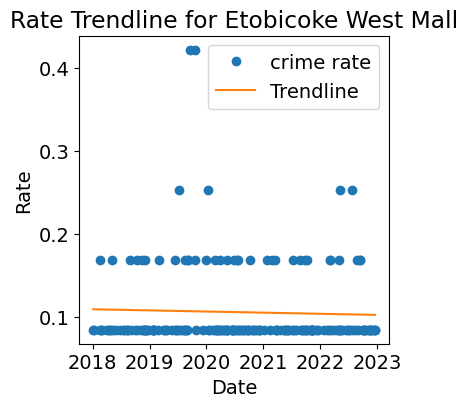

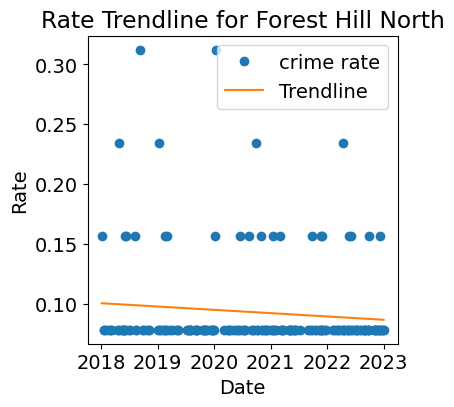

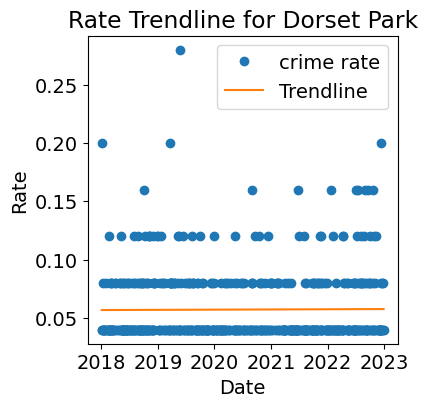

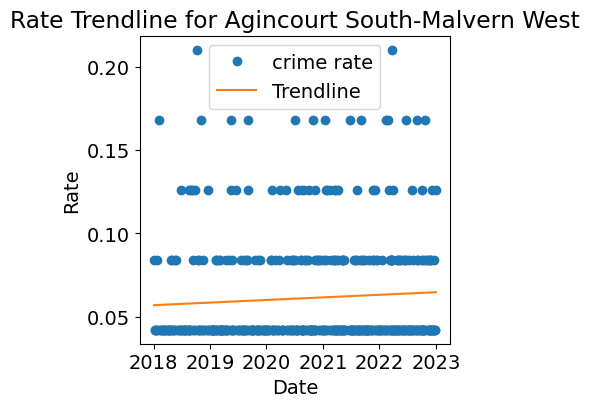

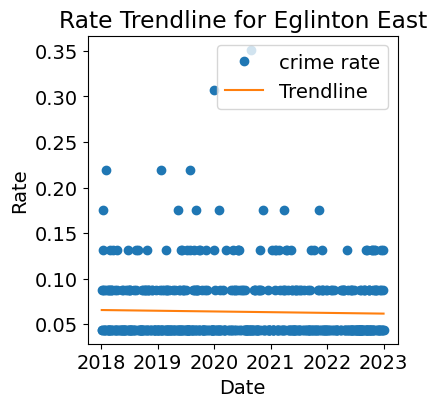

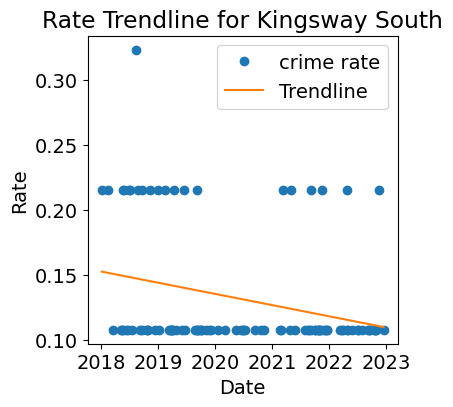

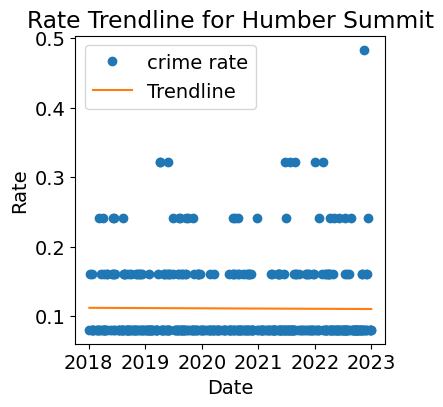

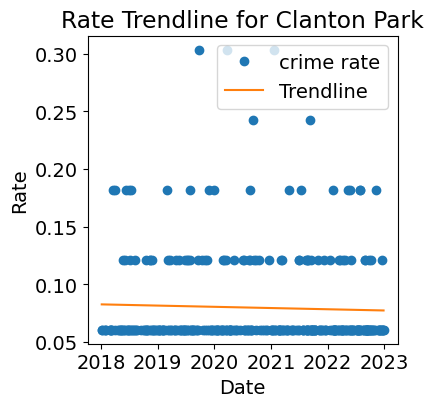

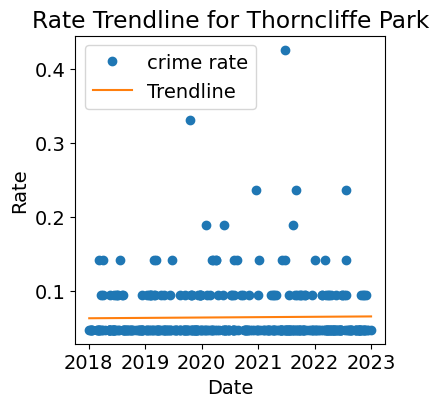

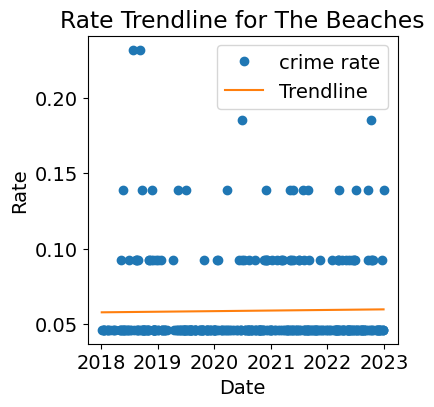

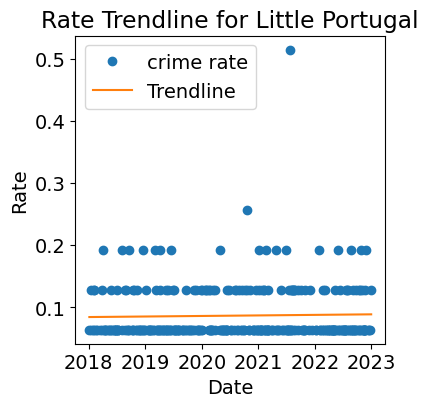

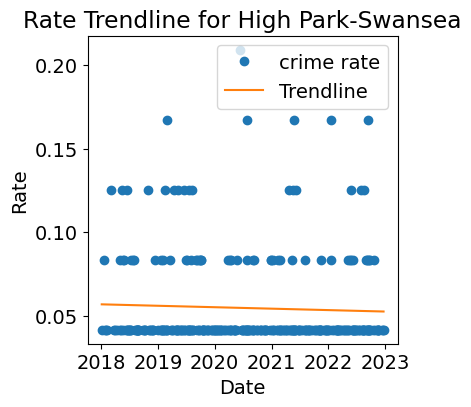

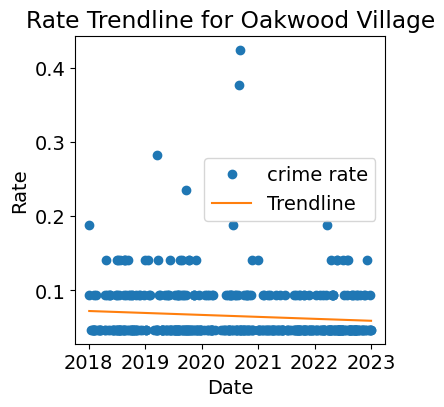

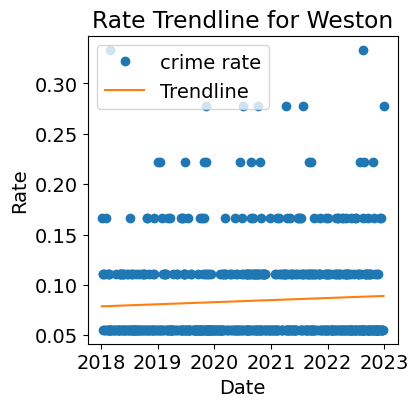

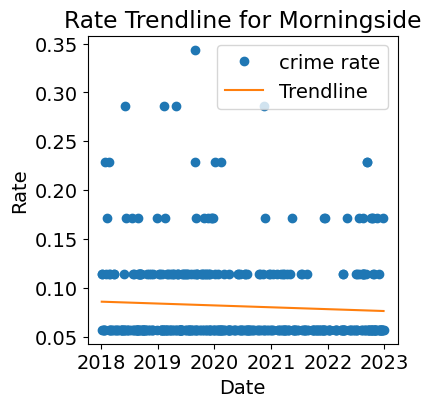

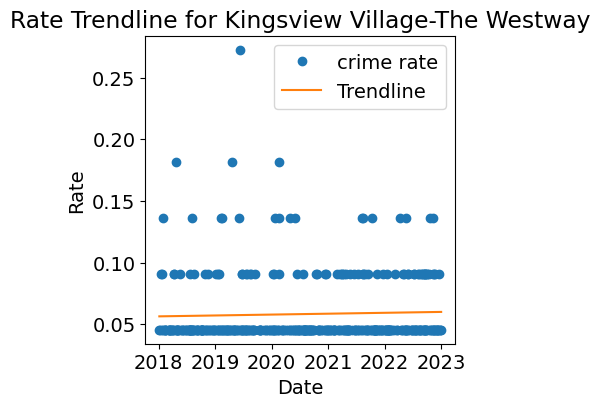

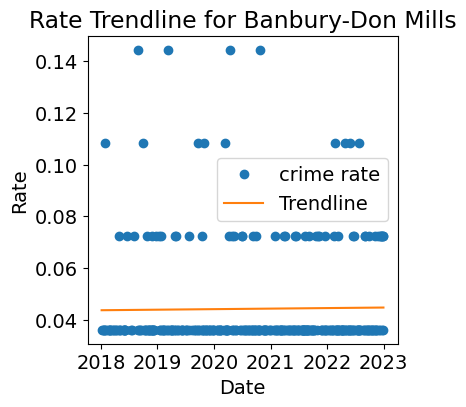

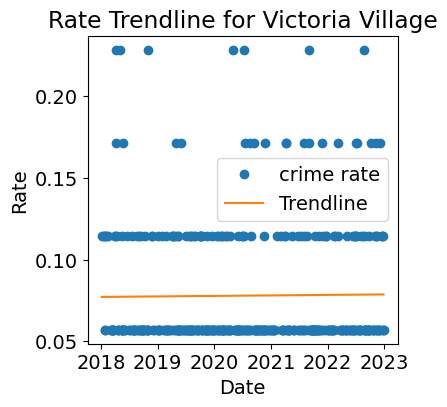

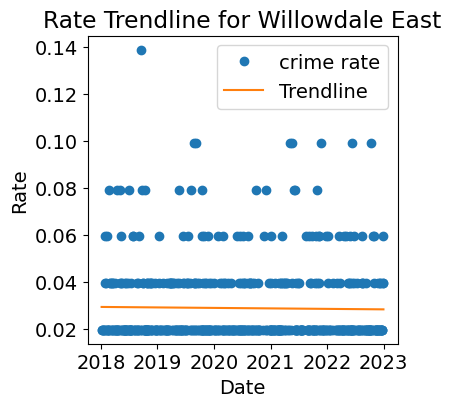

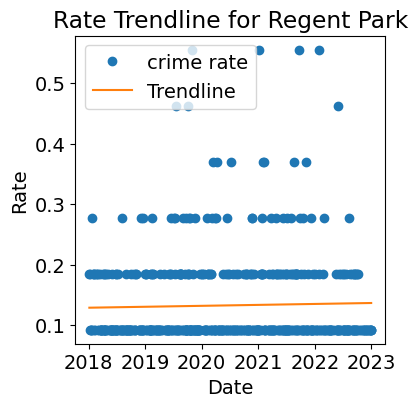

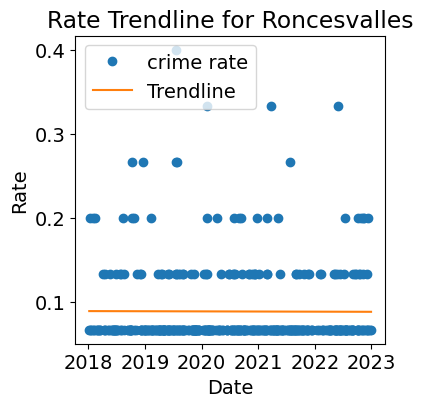

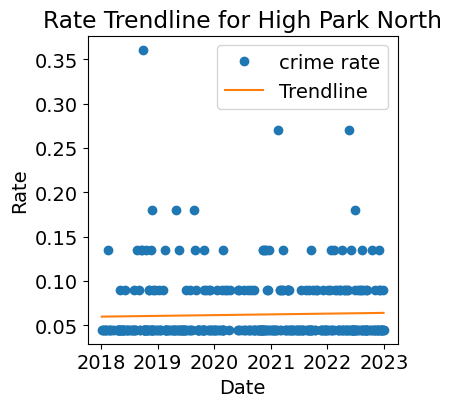

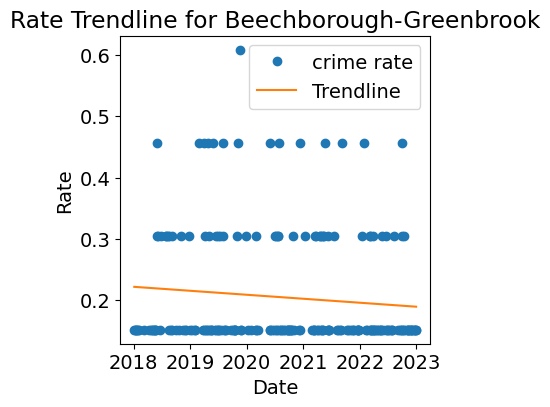

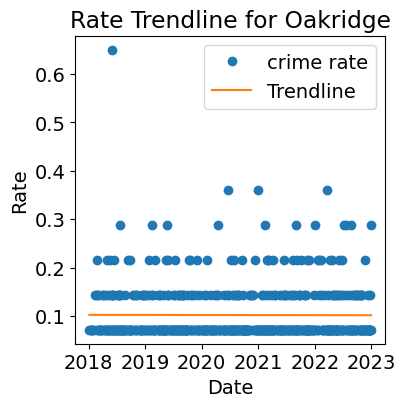

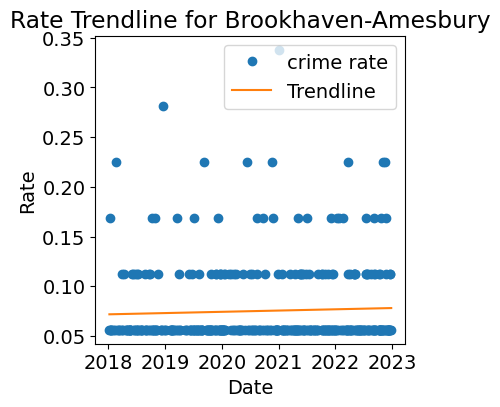

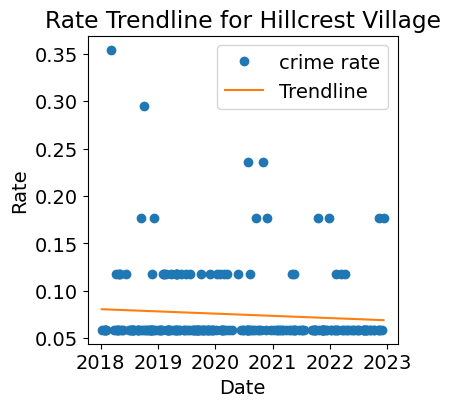

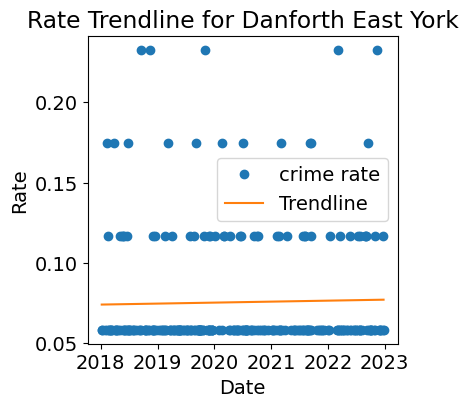

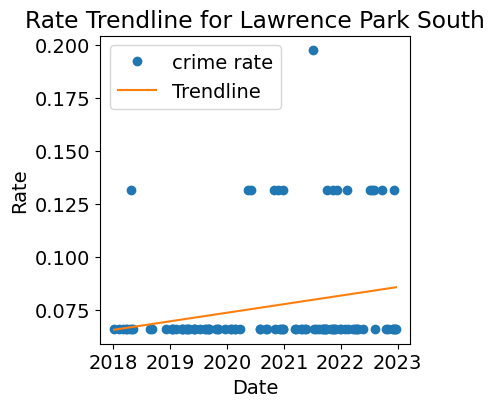

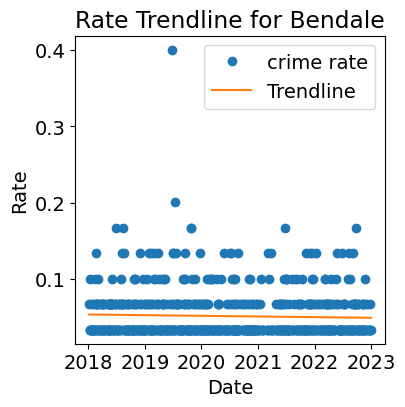

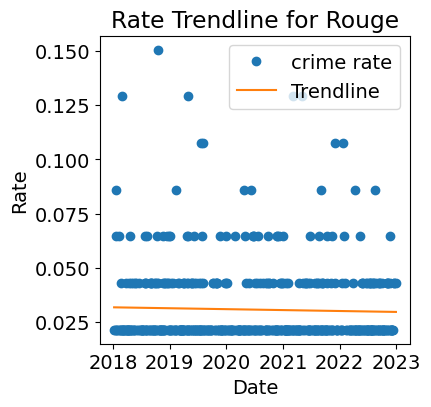

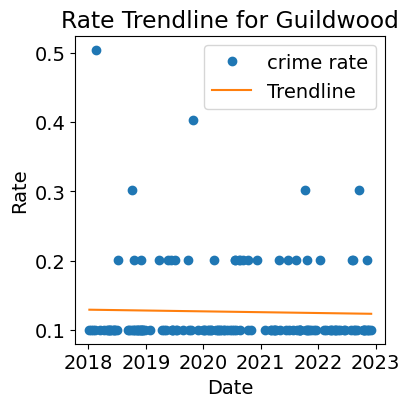

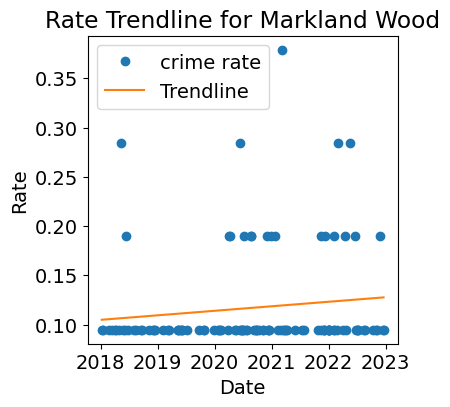

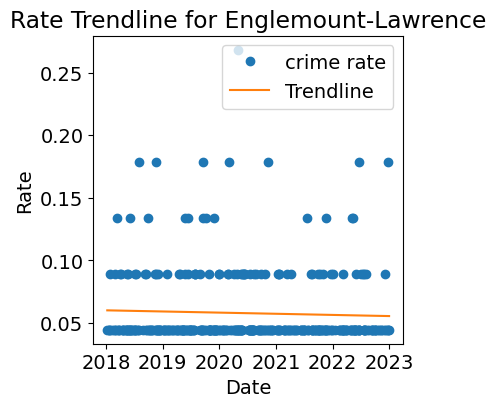

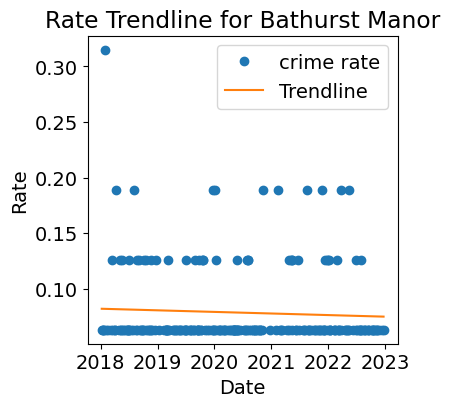

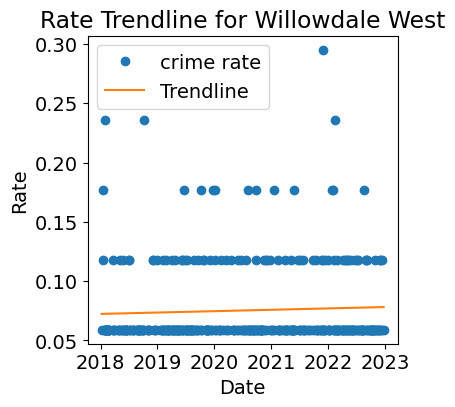

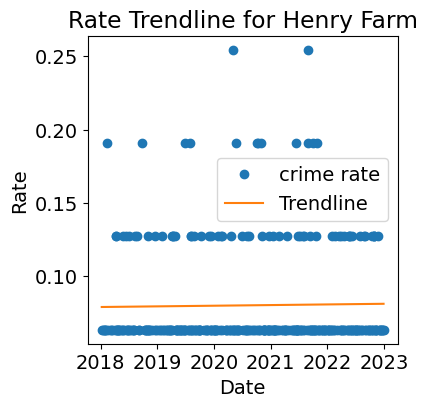

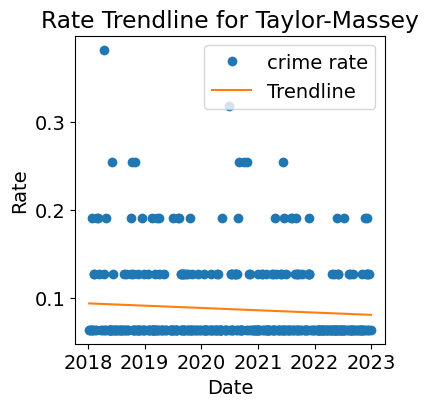

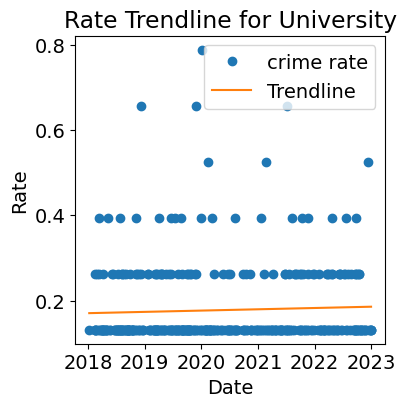

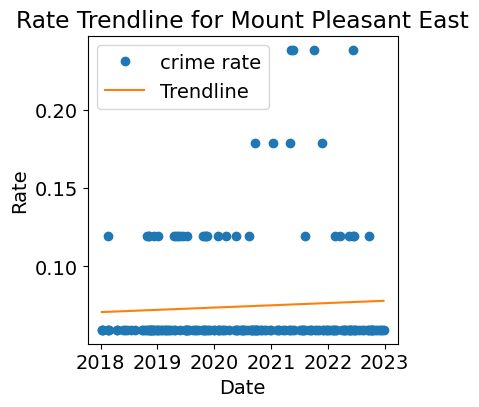

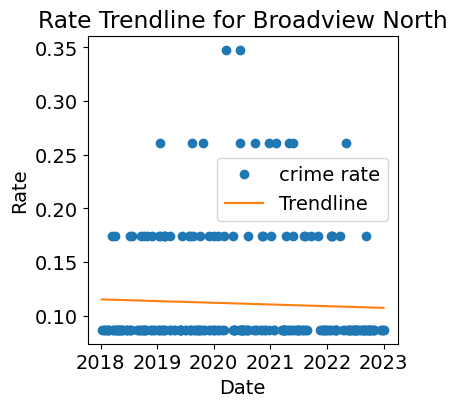

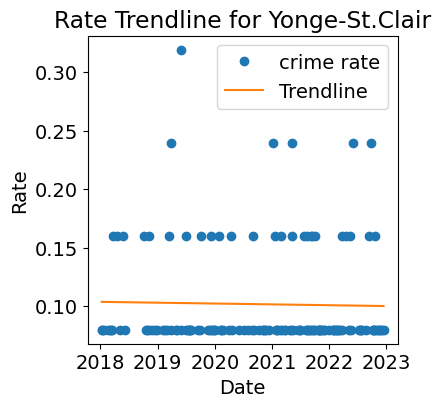

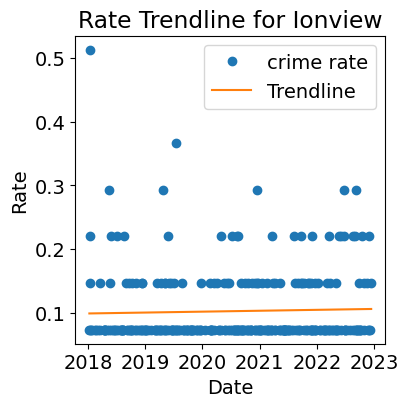

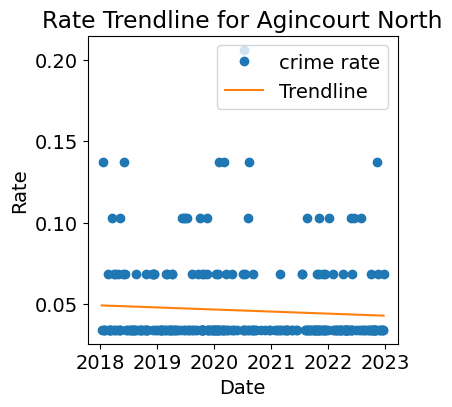

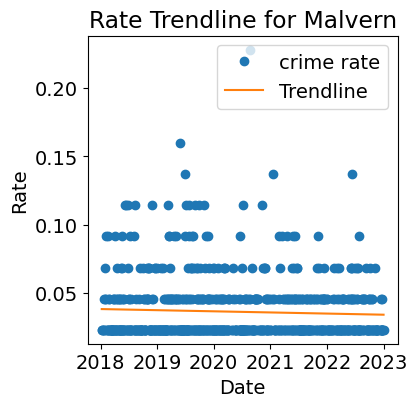

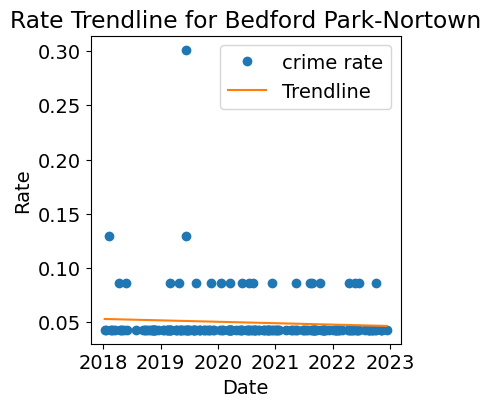

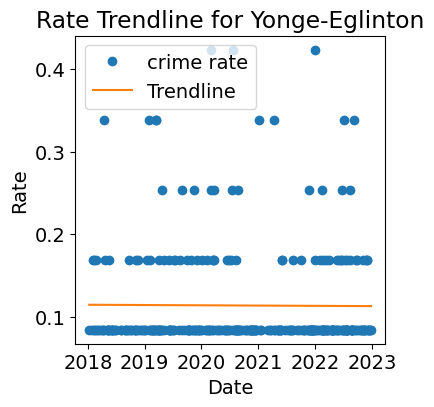

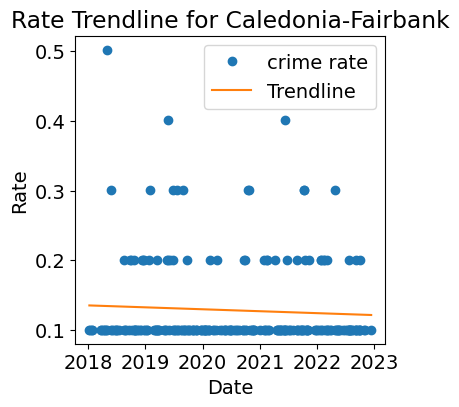

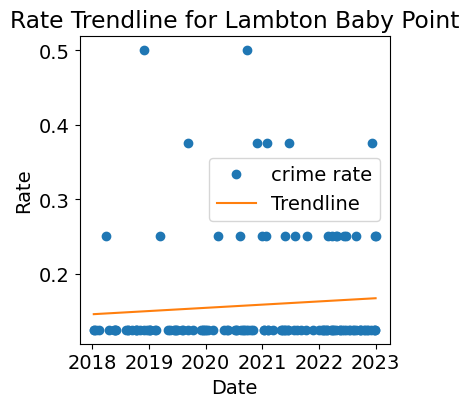

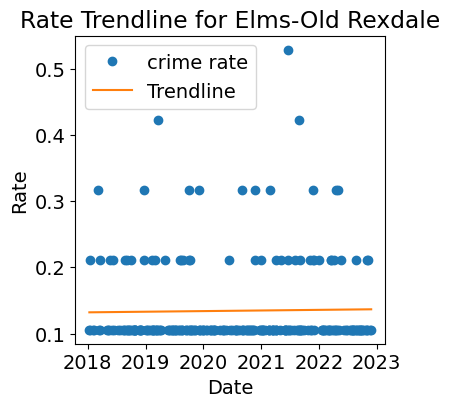

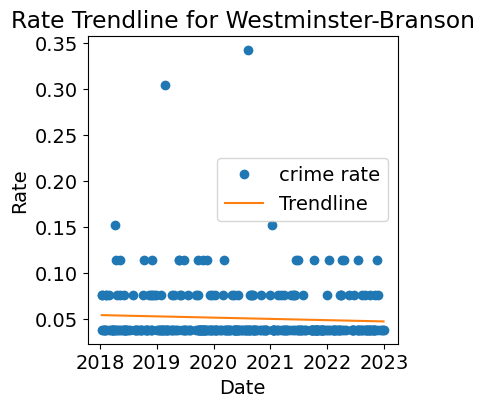

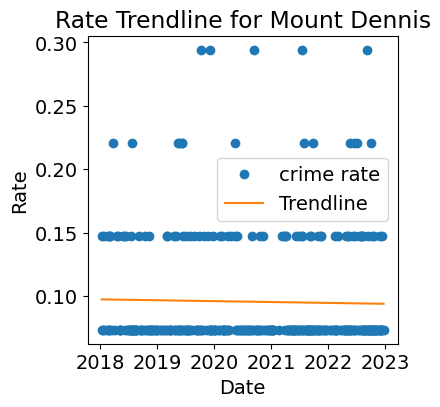

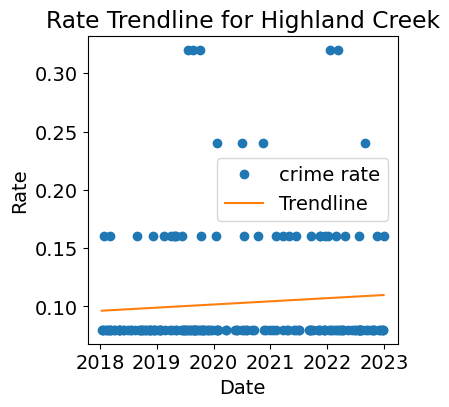

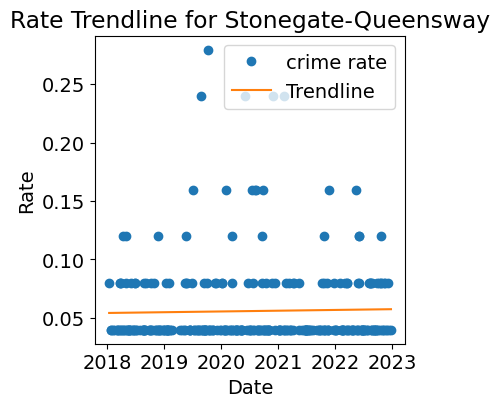

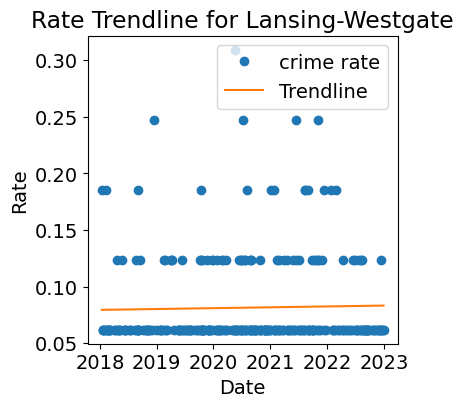

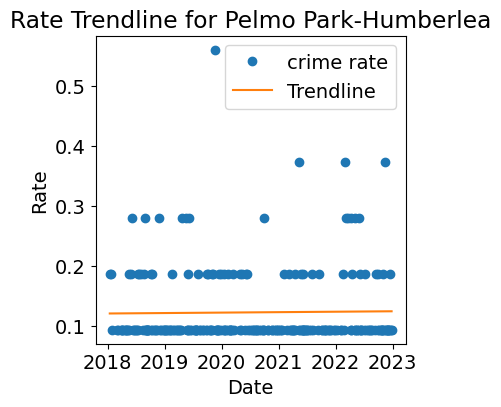

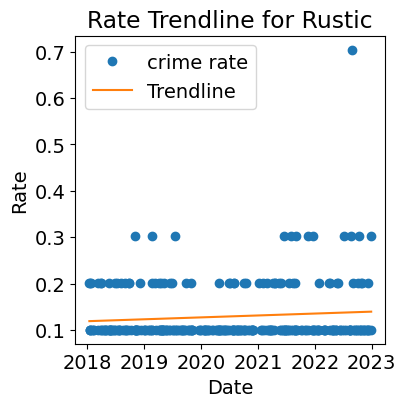

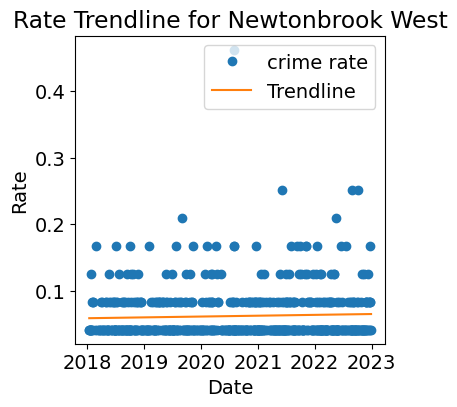

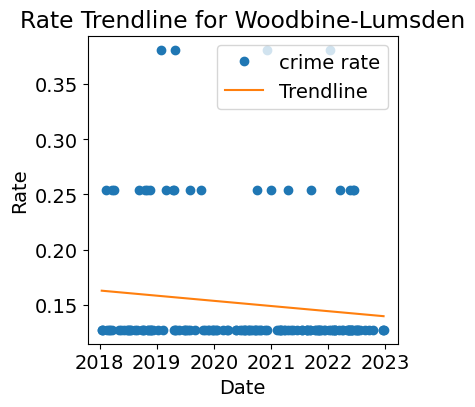

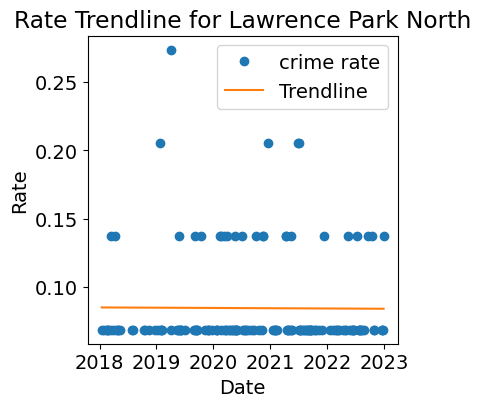

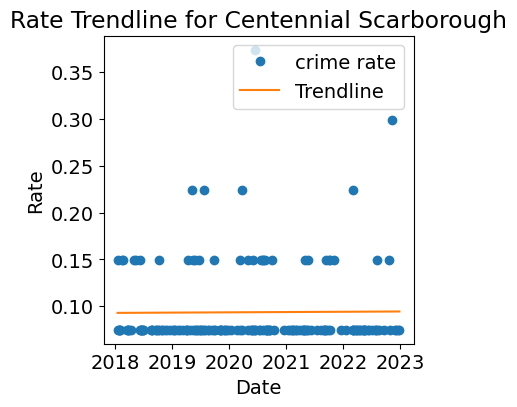

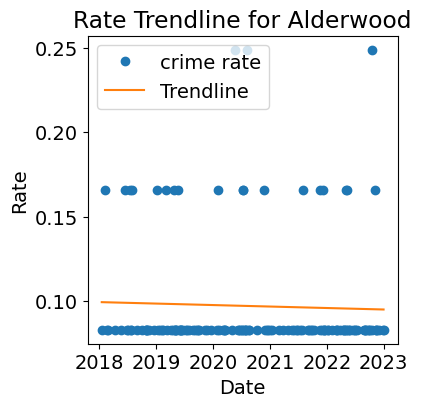

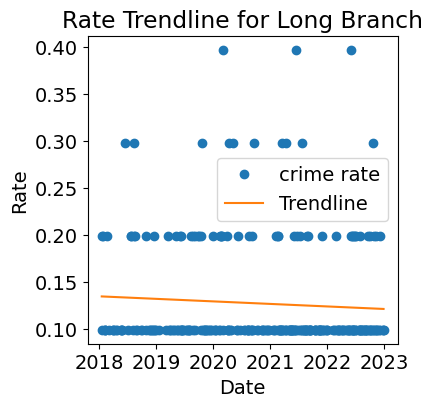

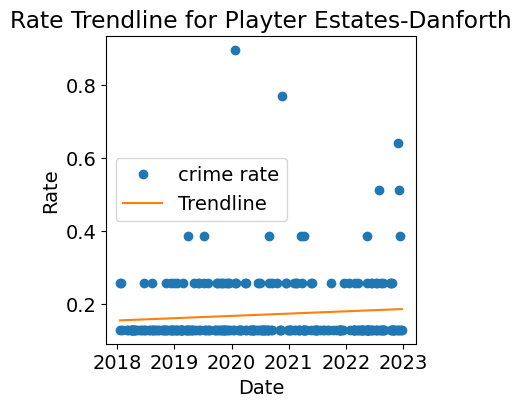

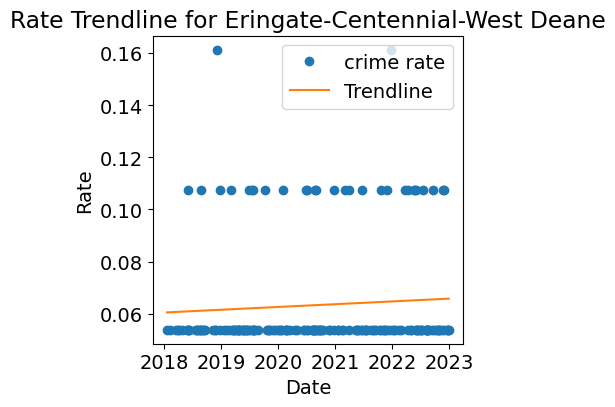

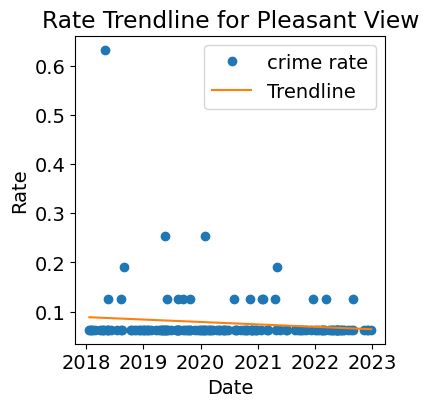

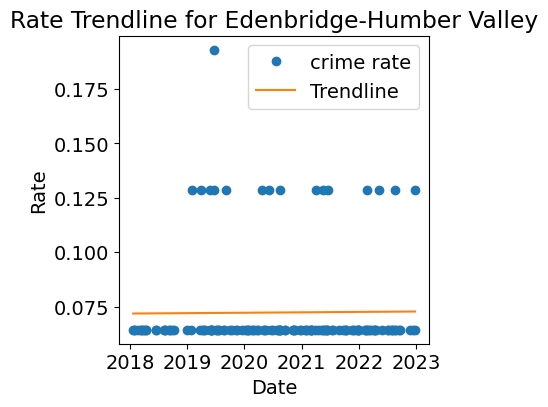

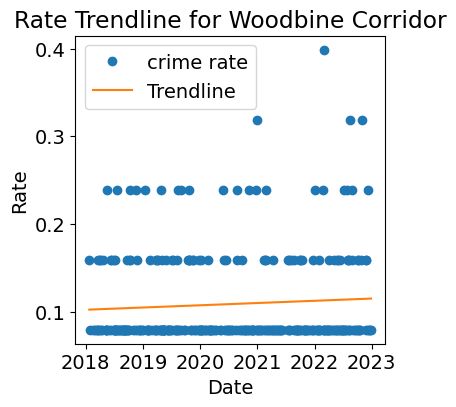

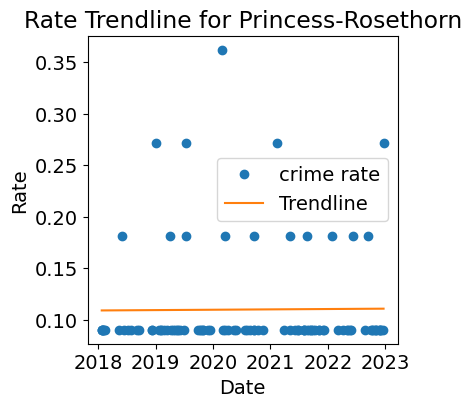

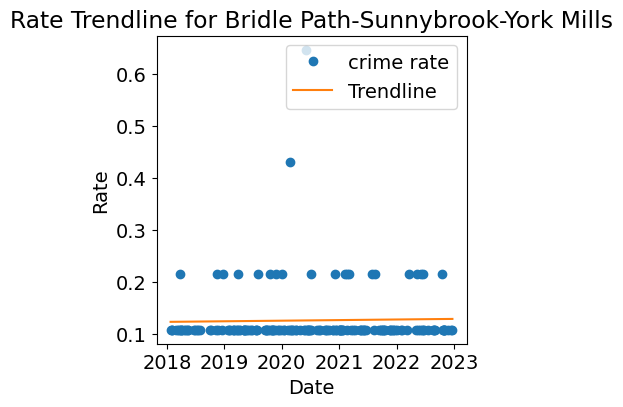

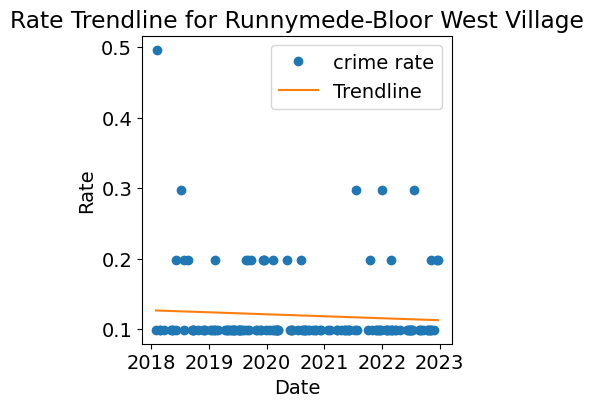

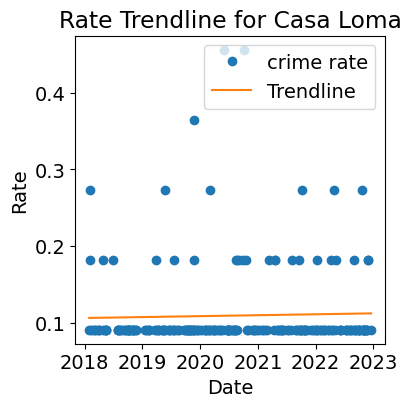

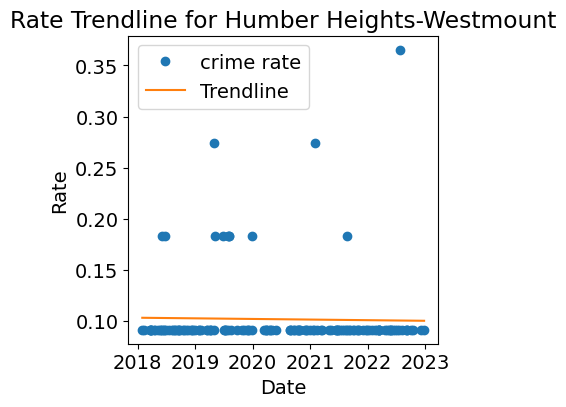

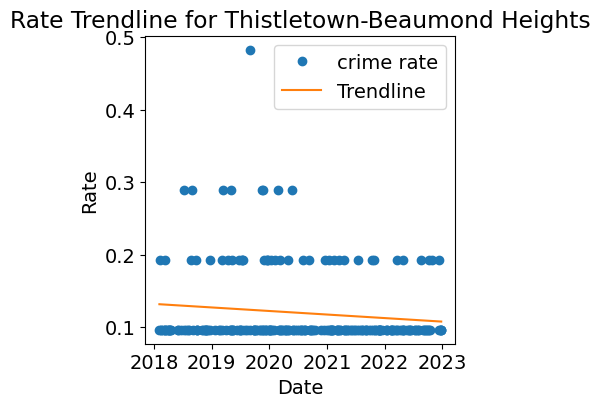

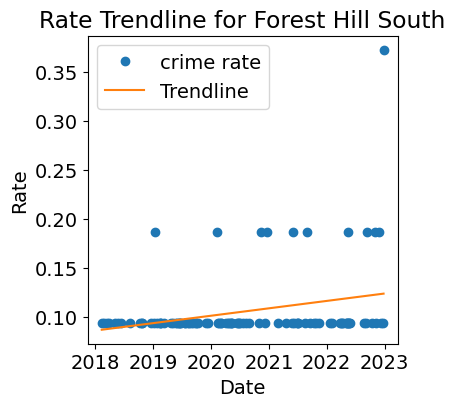

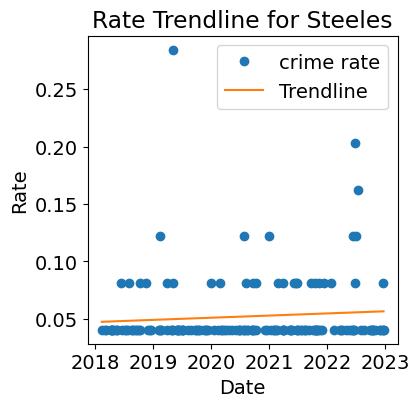

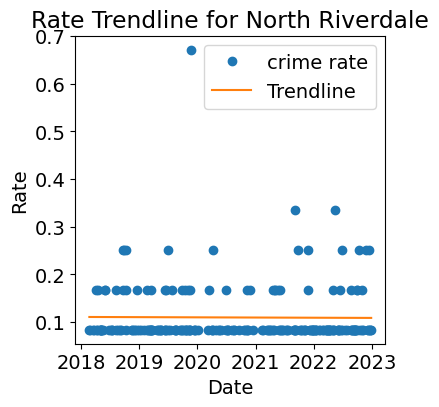

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
neighbourhood = grouped_crimedf['Neighbourhood']

for neighbourhood_140 in neighbourhood.unique():
    #print(neighbourhood)
    df = grouped_crimedf[grouped_crimedf['Neighbourhood'] == neighbourhood_140]
    df['REPORT_DAT'] = pd.to_datetime(df['REPORT_DAT'])
    df['date_num'] = pd.to_numeric(df['REPORT_DAT'])
    coefficients = np.polyfit(df['date_num'], df['crime_rate_per_1000'], 1)
    trendline = np.poly1d(coefficients)
    plt.figure(figsize=(4,4))
    plt.plot(df['REPORT_DAT'], df['crime_rate_per_1000'], 'o', label='crime rate')
    plt.plot(df['REPORT_DAT'], trendline(df['date_num']), label='Trendline')
    plt.xlabel('Date')
    plt.ylabel('Rate')
    plt.title('Rate Trendline for ' + neighbourhood_140)
    plt.legend()
    plt.show()

In [ ]:
treereg = DecisionTreeRegressor(random_state=1)

**Accuracy Metrics : sMAPE : defined how much forecasted value vary from actual value**

In [ ]:
#SMAPE formula : Symmetric mean absolute percentage error
# https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error
# SMAPE = (1/n) * Σ(|forecast – actual| / ((|actual| + |forecast|)/2) * 100

def SMAPE(a, f):
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)

**Dividing the data into Train Test split based on Time series splitting**

In [ ]:
def smape_cv(model,train_X, test_X, train_y, test_y):
    tscv = TimeSeriesSplit(n_splits=3)
    smape_list = []
    model_name = model.__class__.__name__
    for _, (train_index, test_index) in tqdm(enumerate(tscv.split(train_X), start=1),
                                             desc=f'{model_name} Cross Validations', total=3):
        X_train, X_test = train_X.iloc[train_index], train_X.iloc[test_index]
        y_train, y_test = train_y.iloc[train_index], train_y.iloc[test_index]
        clf = model.fit(X_train, y_train)
        pred = clf.predict(X_test)
        smape = SMAPE(y_test, pred)
        smape_list.append(smape)
    return model_name, smape_list

def print_smape_score(model, train_X, test_X, train_y, test_y ):
    model_name, score = smape_cv(model,train_X, test_X, train_y, test_y)
    for i, r in enumerate(score, start=1):
        print(f'{i} FOLDS: {model_name} smape: {r:.4f}')
    print(f'\n{model_name} mean smape: {np.mean(score):.4f}')
    print('='*30)
    return model_name, np.mean(score)

**Model definitions that we are going to pass in the model_list to be applied to the data**

In [ ]:
reg = LinearRegression(n_jobs=-1)
DTree = DecisionTreeRegressor(max_depth=5, min_samples_split=2, min_samples_leaf=2, random_state=1)
rf = RandomForestRegressor(n_estimators=500, criterion='squared_error', max_depth=5, min_samples_split=2,
                           min_samples_leaf=2, random_state=1, n_jobs=-1)

In [ ]:
model_list = [ reg,DTree, rf]

In [ ]:
#submit_df = pd.DataFrame()
model_results = {}
county_and_model = {}

In [ ]:
test_list = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,72,73,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140]

In [ ]:
neighbourhood_dict={}
for neighbourhood in test_list:
    print(f'======================= neighbourhood {neighbourhood} modeling =====================')
    neighbourhood_df = grouped_crimedf[grouped_crimedf['HOOD_140'] == neighbourhood]
    neighbourhood_df['REPORT_DAT'] = pd.to_datetime(grouped_crimedf['REPORT_DAT'])
    neighbourhood_df['date_num'] = pd.to_numeric(neighbourhood_df['REPORT_DAT'])
    #feature_cols=['date_num','DIVISION','LOCATION_TYPE','PREMISES_TYPE','OFFENCE','Neighbourhood','Count_of_police_force','Average Individual Employment Income','Population','Unemployment Rate','Low Income population(LIM-AT)','Total_Event_Count']
    feature_cols=['date_num','HOOD_140','Count_of_police_force','Average Individual Employment Income','Population','Unemployment Rate','Low Income population(LIM-AT)','Total_Event_Count']
    X=neighbourhood_df[feature_cols]
    y=neighbourhood_df['crime_rate_per_1000']
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.30)

    model_dict = {}

    for model in model_list:
        model_name, mean_score = print_smape_score(model,X_train, X_test, y_train, y_test)
        model_dict[model_name] = mean_score
        model_results[neighbourhood] = min(model_dict.values())

    final_model = model_list[list(model_dict.keys()).index(min(model_dict, key=model_dict.get))]

    #predict with final_model
    county_and_model[neighbourhood] = min(model_dict, key=model_dict.get)
    print(county_and_model)

    predict_result = final_model.predict(X_test).tolist()


    df = pd.DataFrame(list(zip(X_test['date_num'].values.tolist(), predict_result)),
              columns=['date_num','crime_rate_per_1000'])
    df['Date'] = pd.to_datetime(df['date_num'], unit='ns').dt.strftime('%Y%m%d')
    neighbourhood_dict[neighbourhood] = df
    #submit_df = submit_df.append(df)

======================= neighbourhood 1 modeling =====================


DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 252.26it/s]


1 FOLDS: DecisionTreeRegressor smape: 0.1289
2 FOLDS: DecisionTreeRegressor smape: 0.1576
3 FOLDS: DecisionTreeRegressor smape: 0.0458

DecisionTreeRegressor mean smape: 0.1108


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:03<00:00,  1.01s/it]


1 FOLDS: RandomForestRegressor smape: 0.3076
2 FOLDS: RandomForestRegressor smape: 0.5241
3 FOLDS: RandomForestRegressor smape: 0.0551

RandomForestRegressor mean smape: 0.2956
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'DecisionTreeRegressor', 6: 'RandomForestRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'RandomForestRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'RandomForestRegressor', 20: 'RandomForestRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'RandomForestRegressor', 24: 'DecisionTreeRegressor', 25: 'RandomForestRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 269.14it/s]


1 FOLDS: DecisionTreeRegressor smape: 1.3232
2 FOLDS: DecisionTreeRegressor smape: 0.1174
3 FOLDS: DecisionTreeRegressor smape: 0.0000

DecisionTreeRegressor mean smape: 0.4802


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]


1 FOLDS: RandomForestRegressor smape: 1.6609
2 FOLDS: RandomForestRegressor smape: 0.2493
3 FOLDS: RandomForestRegressor smape: 0.0358

RandomForestRegressor mean smape: 0.6487
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'DecisionTreeRegressor', 6: 'RandomForestRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'RandomForestRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'RandomForestRegressor', 20: 'RandomForestRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'RandomForestRegressor', 24: 'DecisionTreeRegressor', 25: 'RandomForestRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 236.48it/s]


1 FOLDS: DecisionTreeRegressor smape: 0.0000
2 FOLDS: DecisionTreeRegressor smape: 0.0000
3 FOLDS: DecisionTreeRegressor smape: 0.0000

DecisionTreeRegressor mean smape: 0.0000


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]


1 FOLDS: RandomForestRegressor smape: 0.8128
2 FOLDS: RandomForestRegressor smape: 0.5842
3 FOLDS: RandomForestRegressor smape: 0.5409

RandomForestRegressor mean smape: 0.6460
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'DecisionTreeRegressor', 6: 'RandomForestRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'RandomForestRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'RandomForestRegressor', 20: 'RandomForestRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'RandomForestRegressor', 24: 'DecisionTreeRegressor', 25: 'RandomForestRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 207.38it/s]


1 FOLDS: DecisionTreeRegressor smape: 0.2699
2 FOLDS: DecisionTreeRegressor smape: 1.1308
3 FOLDS: DecisionTreeRegressor smape: 0.0000

DecisionTreeRegressor mean smape: 0.4669


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.45it/s]


1 FOLDS: RandomForestRegressor smape: 0.4867
2 FOLDS: RandomForestRegressor smape: 0.8594
3 FOLDS: RandomForestRegressor smape: 0.2574

RandomForestRegressor mean smape: 0.5345
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'DecisionTreeRegressor', 6: 'RandomForestRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'RandomForestRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'RandomForestRegressor', 20: 'RandomForestRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'RandomForestRegressor', 24: 'DecisionTreeRegressor', 25: 'RandomForestRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 240.40it/s]


1 FOLDS: DecisionTreeRegressor smape: 1.0989
2 FOLDS: DecisionTreeRegressor smape: 0.3663
3 FOLDS: DecisionTreeRegressor smape: 1.8707

DecisionTreeRegressor mean smape: 1.1120


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.45it/s]


1 FOLDS: RandomForestRegressor smape: 0.9657
2 FOLDS: RandomForestRegressor smape: 0.2221
3 FOLDS: RandomForestRegressor smape: 1.8514

RandomForestRegressor mean smape: 1.0131
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'RandomForestRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'RandomForestRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'RandomForestRegressor', 20: 'RandomForestRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'RandomForestRegressor', 24: 'DecisionTreeRegressor', 25: 'RandomForestRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 181.72it/s]


1 FOLDS: DecisionTreeRegressor smape: 0.6279
2 FOLDS: DecisionTreeRegressor smape: 0.0000
3 FOLDS: DecisionTreeRegressor smape: 0.0000

DecisionTreeRegressor mean smape: 0.2093


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.10it/s]


1 FOLDS: RandomForestRegressor smape: 1.0396
2 FOLDS: RandomForestRegressor smape: 0.2549
3 FOLDS: RandomForestRegressor smape: 0.0712

RandomForestRegressor mean smape: 0.4552
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'RandomForestRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'RandomForestRegressor', 20: 'RandomForestRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'RandomForestRegressor', 24: 'DecisionTreeRegressor', 25: 'RandomForestRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 159.49it/s]


1 FOLDS: DecisionTreeRegressor smape: 0.5305
2 FOLDS: DecisionTreeRegressor smape: 0.2299
3 FOLDS: DecisionTreeRegressor smape: 0.0000

DecisionTreeRegressor mean smape: 0.2535


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.37it/s]


1 FOLDS: RandomForestRegressor smape: 0.4435
2 FOLDS: RandomForestRegressor smape: 0.3551
3 FOLDS: RandomForestRegressor smape: 0.3182

RandomForestRegressor mean smape: 0.3722
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'RandomForestRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'RandomForestRegressor', 20: 'RandomForestRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'RandomForestRegressor', 24: 'DecisionTreeRegressor', 25: 'RandomForestRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 211.59it/s]


1 FOLDS: DecisionTreeRegressor smape: 0.6410
2 FOLDS: DecisionTreeRegressor smape: 0.0000
3 FOLDS: DecisionTreeRegressor smape: 3.5185

DecisionTreeRegressor mean smape: 1.3865


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:01<00:00,  1.50it/s]


1 FOLDS: RandomForestRegressor smape: 2.2455
2 FOLDS: RandomForestRegressor smape: 0.5123
3 FOLDS: RandomForestRegressor smape: 2.4514

RandomForestRegressor mean smape: 1.7364
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'RandomForestRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'RandomForestRegressor', 20: 'RandomForestRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'RandomForestRegressor', 24: 'DecisionTreeRegressor', 25: 'RandomForestRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 220.21it/s]


1 FOLDS: DecisionTreeRegressor smape: 1.6667
2 FOLDS: DecisionTreeRegressor smape: 1.8519
3 FOLDS: DecisionTreeRegressor smape: 0.0000

DecisionTreeRegressor mean smape: 1.1728


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:01<00:00,  1.52it/s]


1 FOLDS: RandomForestRegressor smape: 6.2134
2 FOLDS: RandomForestRegressor smape: 1.1209
3 FOLDS: RandomForestRegressor smape: 0.4265

RandomForestRegressor mean smape: 2.5869
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'RandomForestRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'RandomForestRegressor', 20: 'RandomForestRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'RandomForestRegressor', 24: 'DecisionTreeRegressor', 25: 'RandomForestRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 226.93it/s]


1 FOLDS: DecisionTreeRegressor smape: 4.0210
2 FOLDS: DecisionTreeRegressor smape: 18.1579
3 FOLDS: DecisionTreeRegressor smape: 0.0000

DecisionTreeRegressor mean smape: 7.3930


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.43it/s]


1 FOLDS: RandomForestRegressor smape: 14.8629
2 FOLDS: RandomForestRegressor smape: 9.3742
3 FOLDS: RandomForestRegressor smape: 0.6740

RandomForestRegressor mean smape: 8.3037
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'RandomForestRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'RandomForestRegressor', 20: 'RandomForestRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'RandomForestRegressor', 24: 'DecisionTreeRegressor', 25: 'RandomForestRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeR

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 250.31it/s]


1 FOLDS: DecisionTreeRegressor smape: 0.0000
2 FOLDS: DecisionTreeRegressor smape: 2.5806
3 FOLDS: DecisionTreeRegressor smape: 0.0000

DecisionTreeRegressor mean smape: 0.8602


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]


1 FOLDS: RandomForestRegressor smape: 0.4718
2 FOLDS: RandomForestRegressor smape: 2.6329
3 FOLDS: RandomForestRegressor smape: 0.3343

RandomForestRegressor mean smape: 1.1463
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'RandomForestRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'RandomForestRegressor', 20: 'RandomForestRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'RandomForestRegressor', 24: 'DecisionTreeRegressor', 25: 'RandomForestRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 211.31it/s]


1 FOLDS: DecisionTreeRegressor smape: 3.5088
2 FOLDS: DecisionTreeRegressor smape: 4.2105
3 FOLDS: DecisionTreeRegressor smape: 0.8097

DecisionTreeRegressor mean smape: 2.8430


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]


1 FOLDS: RandomForestRegressor smape: 11.5056
2 FOLDS: RandomForestRegressor smape: 3.7914
3 FOLDS: RandomForestRegressor smape: 1.8428

RandomForestRegressor mean smape: 5.7133
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'RandomForestRegressor', 20: 'RandomForestRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'RandomForestRegressor', 24: 'DecisionTreeRegressor', 25: 'RandomForestRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeR

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 231.45it/s]


1 FOLDS: DecisionTreeRegressor smape: 3.2086
2 FOLDS: DecisionTreeRegressor smape: 4.5675
3 FOLDS: DecisionTreeRegressor smape: 0.0000

DecisionTreeRegressor mean smape: 2.5920


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]


1 FOLDS: RandomForestRegressor smape: 3.4025
2 FOLDS: RandomForestRegressor smape: 5.6822
3 FOLDS: RandomForestRegressor smape: 0.0757

RandomForestRegressor mean smape: 3.0535
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'RandomForestRegressor', 20: 'RandomForestRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'RandomForestRegressor', 24: 'DecisionTreeRegressor', 25: 'RandomForestRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 194.61it/s]


1 FOLDS: DecisionTreeRegressor smape: 0.1599
2 FOLDS: DecisionTreeRegressor smape: 0.3197
3 FOLDS: DecisionTreeRegressor smape: 0.0000

DecisionTreeRegressor mean smape: 0.1599


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]


1 FOLDS: RandomForestRegressor smape: 0.2791
2 FOLDS: RandomForestRegressor smape: 0.3306
3 FOLDS: RandomForestRegressor smape: 0.1354

RandomForestRegressor mean smape: 0.2484
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'RandomForestRegressor', 20: 'RandomForestRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'RandomForestRegressor', 24: 'DecisionTreeRegressor', 25: 'RandomForestRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 209.81it/s]


1 FOLDS: DecisionTreeRegressor smape: 0.0000
2 FOLDS: DecisionTreeRegressor smape: 0.0000
3 FOLDS: DecisionTreeRegressor smape: 0.0000

DecisionTreeRegressor mean smape: 0.0000


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.48it/s]


1 FOLDS: RandomForestRegressor smape: 1.7980
2 FOLDS: RandomForestRegressor smape: 0.0000
3 FOLDS: RandomForestRegressor smape: 0.0000

RandomForestRegressor mean smape: 0.5993
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'RandomForestRegressor', 20: 'RandomForestRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'RandomForestRegressor', 24: 'DecisionTreeRegressor', 25: 'RandomForestRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 250.47it/s]


1 FOLDS: DecisionTreeRegressor smape: 1.1345
2 FOLDS: DecisionTreeRegressor smape: 1.4354
3 FOLDS: DecisionTreeRegressor smape: 0.0000

DecisionTreeRegressor mean smape: 0.8566


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]


1 FOLDS: RandomForestRegressor smape: 1.0257
2 FOLDS: RandomForestRegressor smape: 1.9268
3 FOLDS: RandomForestRegressor smape: 0.3869

RandomForestRegressor mean smape: 1.1131
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'RandomForestRegressor', 20: 'RandomForestRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'RandomForestRegressor', 24: 'DecisionTreeRegressor', 25: 'RandomForestRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 192.31it/s]


1 FOLDS: DecisionTreeRegressor smape: 0.4158
2 FOLDS: DecisionTreeRegressor smape: 0.3861
3 FOLDS: DecisionTreeRegressor smape: 0.3003

DecisionTreeRegressor mean smape: 0.3674


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.35it/s]


1 FOLDS: RandomForestRegressor smape: 0.2759
2 FOLDS: RandomForestRegressor smape: 0.4693
3 FOLDS: RandomForestRegressor smape: 0.6449

RandomForestRegressor mean smape: 0.4633
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'RandomForestRegressor', 20: 'RandomForestRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'RandomForestRegressor', 24: 'DecisionTreeRegressor', 25: 'RandomForestRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 229.41it/s]


1 FOLDS: DecisionTreeRegressor smape: 0.3140
2 FOLDS: DecisionTreeRegressor smape: 0.2148
3 FOLDS: DecisionTreeRegressor smape: 0.5861

DecisionTreeRegressor mean smape: 0.3716


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]


1 FOLDS: RandomForestRegressor smape: 1.2902
2 FOLDS: RandomForestRegressor smape: 0.2188
3 FOLDS: RandomForestRegressor smape: 0.7893

RandomForestRegressor mean smape: 0.7661
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'RandomForestRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'RandomForestRegressor', 24: 'DecisionTreeRegressor', 25: 'RandomForestRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 205.50it/s]


1 FOLDS: DecisionTreeRegressor smape: 0.9259
2 FOLDS: DecisionTreeRegressor smape: 0.6410
3 FOLDS: DecisionTreeRegressor smape: 1.6667

DecisionTreeRegressor mean smape: 1.0779


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.49it/s]


1 FOLDS: RandomForestRegressor smape: 1.5147
2 FOLDS: RandomForestRegressor smape: 1.1925
3 FOLDS: RandomForestRegressor smape: 1.6648

RandomForestRegressor mean smape: 1.4573
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'RandomForestRegressor', 24: 'DecisionTreeRegressor', 25: 'RandomForestRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 194.66it/s]


1 FOLDS: DecisionTreeRegressor smape: 0.0000
2 FOLDS: DecisionTreeRegressor smape: 0.0000
3 FOLDS: DecisionTreeRegressor smape: 0.0000

DecisionTreeRegressor mean smape: 0.0000


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.43it/s]


1 FOLDS: RandomForestRegressor smape: 0.5882
2 FOLDS: RandomForestRegressor smape: 0.0842
3 FOLDS: RandomForestRegressor smape: 0.0791

RandomForestRegressor mean smape: 0.2505
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'RandomForestRegressor', 24: 'DecisionTreeRegressor', 25: 'RandomForestRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 208.02it/s]


1 FOLDS: DecisionTreeRegressor smape: 1.3198
2 FOLDS: DecisionTreeRegressor smape: 0.2674
3 FOLDS: DecisionTreeRegressor smape: 0.3836

DecisionTreeRegressor mean smape: 0.6569


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]


1 FOLDS: RandomForestRegressor smape: 1.7125
2 FOLDS: RandomForestRegressor smape: 0.2630
3 FOLDS: RandomForestRegressor smape: 0.2672

RandomForestRegressor mean smape: 0.7476
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'RandomForestRegressor', 24: 'DecisionTreeRegressor', 25: 'RandomForestRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 158.64it/s]


1 FOLDS: DecisionTreeRegressor smape: 0.9569
2 FOLDS: DecisionTreeRegressor smape: 1.3487
3 FOLDS: DecisionTreeRegressor smape: 0.0000

DecisionTreeRegressor mean smape: 0.7685


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]


1 FOLDS: RandomForestRegressor smape: 1.2722
2 FOLDS: RandomForestRegressor smape: 1.1101
3 FOLDS: RandomForestRegressor smape: 0.1586

RandomForestRegressor mean smape: 0.8470
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'RandomForestRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 121.88it/s]


1 FOLDS: DecisionTreeRegressor smape: 0.5128
2 FOLDS: DecisionTreeRegressor smape: 0.0000
3 FOLDS: DecisionTreeRegressor smape: 0.0733

DecisionTreeRegressor mean smape: 0.1954


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.34it/s]


1 FOLDS: RandomForestRegressor smape: 0.4476
2 FOLDS: RandomForestRegressor smape: 0.1098
3 FOLDS: RandomForestRegressor smape: 0.0390

RandomForestRegressor mean smape: 0.1988
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'RandomForestRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 269.07it/s]


1 FOLDS: DecisionTreeRegressor smape: 0.5290
2 FOLDS: DecisionTreeRegressor smape: 0.0675
3 FOLDS: DecisionTreeRegressor smape: 0.0000

DecisionTreeRegressor mean smape: 0.1988


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]


1 FOLDS: RandomForestRegressor smape: 1.0084
2 FOLDS: RandomForestRegressor smape: 0.0712
3 FOLDS: RandomForestRegressor smape: 0.0132

RandomForestRegressor mean smape: 0.3643
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 176.32it/s]


1 FOLDS: DecisionTreeRegressor smape: 0.2243
2 FOLDS: DecisionTreeRegressor smape: 0.0352
3 FOLDS: DecisionTreeRegressor smape: 0.0000

DecisionTreeRegressor mean smape: 0.0865


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.35it/s]


1 FOLDS: RandomForestRegressor smape: 0.2964
2 FOLDS: RandomForestRegressor smape: 0.0902
3 FOLDS: RandomForestRegressor smape: 0.0047

RandomForestRegressor mean smape: 0.1304
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 195.71it/s]


1 FOLDS: DecisionTreeRegressor smape: 0.6953
2 FOLDS: DecisionTreeRegressor smape: 0.1432
3 FOLDS: DecisionTreeRegressor smape: 0.0775

DecisionTreeRegressor mean smape: 0.3053


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]


1 FOLDS: RandomForestRegressor smape: 0.8905
2 FOLDS: RandomForestRegressor smape: 0.0748
3 FOLDS: RandomForestRegressor smape: 0.0838

RandomForestRegressor mean smape: 0.3497
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 221.00it/s]


1 FOLDS: DecisionTreeRegressor smape: 0.8163
2 FOLDS: DecisionTreeRegressor smape: 2.5397
3 FOLDS: DecisionTreeRegressor smape: 0.0000

DecisionTreeRegressor mean smape: 1.1187


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.49it/s]


1 FOLDS: RandomForestRegressor smape: 0.9274
2 FOLDS: RandomForestRegressor smape: 2.1064
3 FOLDS: RandomForestRegressor smape: 1.5491

RandomForestRegressor mean smape: 1.5276
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 149.22it/s]


1 FOLDS: DecisionTreeRegressor smape: 0.0000
2 FOLDS: DecisionTreeRegressor smape: 1.7391
3 FOLDS: DecisionTreeRegressor smape: 1.7391

DecisionTreeRegressor mean smape: 1.1594


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.37it/s]


1 FOLDS: RandomForestRegressor smape: 0.1437
2 FOLDS: RandomForestRegressor smape: 1.7391
3 FOLDS: RandomForestRegressor smape: 2.1651

RandomForestRegressor mean smape: 1.3493
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 269.75it/s]


1 FOLDS: DecisionTreeRegressor smape: 0.0000
2 FOLDS: DecisionTreeRegressor smape: 0.5714
3 FOLDS: DecisionTreeRegressor smape: 0.0000

DecisionTreeRegressor mean smape: 0.1905


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.36it/s]


1 FOLDS: RandomForestRegressor smape: 0.8103
2 FOLDS: RandomForestRegressor smape: 0.6035
3 FOLDS: RandomForestRegressor smape: 0.1443

RandomForestRegressor mean smape: 0.5194
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 155.39it/s]


1 FOLDS: DecisionTreeRegressor smape: 0.0000
2 FOLDS: DecisionTreeRegressor smape: 0.0000
3 FOLDS: DecisionTreeRegressor smape: 0.0000

DecisionTreeRegressor mean smape: 0.0000


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]


1 FOLDS: RandomForestRegressor smape: 0.1921
2 FOLDS: RandomForestRegressor smape: 0.0720
3 FOLDS: RandomForestRegressor smape: 0.0511

RandomForestRegressor mean smape: 0.1051
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 166.94it/s]


1 FOLDS: DecisionTreeRegressor smape: 0.0000
2 FOLDS: DecisionTreeRegressor smape: 0.6250
3 FOLDS: DecisionTreeRegressor smape: 0.0000

DecisionTreeRegressor mean smape: 0.2083


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.43it/s]


1 FOLDS: RandomForestRegressor smape: 0.2410
2 FOLDS: RandomForestRegressor smape: 1.0368
3 FOLDS: RandomForestRegressor smape: 0.0832

RandomForestRegressor mean smape: 0.4537
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 212.12it/s]


1 FOLDS: DecisionTreeRegressor smape: 0.0000
2 FOLDS: DecisionTreeRegressor smape: 1.3095
3 FOLDS: DecisionTreeRegressor smape: 0.0000

DecisionTreeRegressor mean smape: 0.4365


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]


1 FOLDS: RandomForestRegressor smape: 1.7277
2 FOLDS: RandomForestRegressor smape: 1.4048
3 FOLDS: RandomForestRegressor smape: 0.4682

RandomForestRegressor mean smape: 1.2003
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 208.46it/s]


1 FOLDS: DecisionTreeRegressor smape: 1.5275
2 FOLDS: DecisionTreeRegressor smape: 0.0000
3 FOLDS: DecisionTreeRegressor smape: 0.0000

DecisionTreeRegressor mean smape: 0.5092


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.43it/s]


1 FOLDS: RandomForestRegressor smape: 1.5611
2 FOLDS: RandomForestRegressor smape: 1.8533
3 FOLDS: RandomForestRegressor smape: 0.3639

RandomForestRegressor mean smape: 1.2595
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 152.86it/s]


1 FOLDS: DecisionTreeRegressor smape: 7.0723
2 FOLDS: DecisionTreeRegressor smape: 0.9890
3 FOLDS: DecisionTreeRegressor smape: 1.1111

DecisionTreeRegressor mean smape: 3.0575


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]


1 FOLDS: RandomForestRegressor smape: 5.7107
2 FOLDS: RandomForestRegressor smape: 0.7816
3 FOLDS: RandomForestRegressor smape: 1.5987

RandomForestRegressor mean smape: 2.6970
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 172.45it/s]


1 FOLDS: DecisionTreeRegressor smape: 0.7584
2 FOLDS: DecisionTreeRegressor smape: 0.0000
3 FOLDS: DecisionTreeRegressor smape: 0.0000

DecisionTreeRegressor mean smape: 0.2528


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.37it/s]


1 FOLDS: RandomForestRegressor smape: 1.0012
2 FOLDS: RandomForestRegressor smape: 0.0564
3 FOLDS: RandomForestRegressor smape: 0.1468

RandomForestRegressor mean smape: 0.4015
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 161.17it/s]


1 FOLDS: DecisionTreeRegressor smape: 2.0673
2 FOLDS: DecisionTreeRegressor smape: 0.0000
3 FOLDS: DecisionTreeRegressor smape: 0.8929

DecisionTreeRegressor mean smape: 0.9867


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]


1 FOLDS: RandomForestRegressor smape: 2.3337
2 FOLDS: RandomForestRegressor smape: 1.0465
3 FOLDS: RandomForestRegressor smape: 1.1056

RandomForestRegressor mean smape: 1.4953
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 134.63it/s]


1 FOLDS: DecisionTreeRegressor smape: 0.5602
2 FOLDS: DecisionTreeRegressor smape: 0.0000
3 FOLDS: DecisionTreeRegressor smape: 2.6611

DecisionTreeRegressor mean smape: 1.0738


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]


1 FOLDS: RandomForestRegressor smape: 2.6465
2 FOLDS: RandomForestRegressor smape: 0.1105
3 FOLDS: RandomForestRegressor smape: 2.6168

RandomForestRegressor mean smape: 1.7913
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 224.92it/s]


1 FOLDS: DecisionTreeRegressor smape: 1.1765
2 FOLDS: DecisionTreeRegressor smape: 0.0000
3 FOLDS: DecisionTreeRegressor smape: 3.2680

DecisionTreeRegressor mean smape: 1.4815


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]


1 FOLDS: RandomForestRegressor smape: 6.4124
2 FOLDS: RandomForestRegressor smape: 0.7652
3 FOLDS: RandomForestRegressor smape: 3.1594

RandomForestRegressor mean smape: 3.4457
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 159.88it/s]


1 FOLDS: DecisionTreeRegressor smape: 0.0000
2 FOLDS: DecisionTreeRegressor smape: 0.6969
3 FOLDS: DecisionTreeRegressor smape: 0.6504

DecisionTreeRegressor mean smape: 0.4491


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.37it/s]


1 FOLDS: RandomForestRegressor smape: 0.9341
2 FOLDS: RandomForestRegressor smape: 1.7289
3 FOLDS: RandomForestRegressor smape: 1.1142

RandomForestRegressor mean smape: 1.2591
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 151.53it/s]


1 FOLDS: DecisionTreeRegressor smape: 3.4483
2 FOLDS: DecisionTreeRegressor smape: 2.2989
3 FOLDS: DecisionTreeRegressor smape: 2.2989

DecisionTreeRegressor mean smape: 2.6820


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.45it/s]


1 FOLDS: RandomForestRegressor smape: 3.9988
2 FOLDS: RandomForestRegressor smape: 2.6054
3 FOLDS: RandomForestRegressor smape: 1.8441

RandomForestRegressor mean smape: 2.8161
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 167.64it/s]


1 FOLDS: DecisionTreeRegressor smape: 0.6897
2 FOLDS: DecisionTreeRegressor smape: 0.7958
3 FOLDS: DecisionTreeRegressor smape: 0.9852

DecisionTreeRegressor mean smape: 0.8235


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]


1 FOLDS: RandomForestRegressor smape: 1.2647
2 FOLDS: RandomForestRegressor smape: 0.9886
3 FOLDS: RandomForestRegressor smape: 0.9894

RandomForestRegressor mean smape: 1.0809
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 199.10it/s]


1 FOLDS: DecisionTreeRegressor smape: 1.2601
2 FOLDS: DecisionTreeRegressor smape: 0.0000
3 FOLDS: DecisionTreeRegressor smape: 0.0000

DecisionTreeRegressor mean smape: 0.4200


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]


1 FOLDS: RandomForestRegressor smape: 2.8230
2 FOLDS: RandomForestRegressor smape: 0.2222
3 FOLDS: RandomForestRegressor smape: 0.2780

RandomForestRegressor mean smape: 1.1077
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 150.12it/s]


1 FOLDS: DecisionTreeRegressor smape: 1.0084
2 FOLDS: DecisionTreeRegressor smape: 0.0000
3 FOLDS: DecisionTreeRegressor smape: 0.0000

DecisionTreeRegressor mean smape: 0.3361


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]


1 FOLDS: RandomForestRegressor smape: 1.3418
2 FOLDS: RandomForestRegressor smape: 0.1029
3 FOLDS: RandomForestRegressor smape: 0.0795

RandomForestRegressor mean smape: 0.5081
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 171.71it/s]


1 FOLDS: DecisionTreeRegressor smape: 0.2469
2 FOLDS: DecisionTreeRegressor smape: 0.2020
3 FOLDS: DecisionTreeRegressor smape: 0.2024

DecisionTreeRegressor mean smape: 0.2171


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.35it/s]


1 FOLDS: RandomForestRegressor smape: 0.3971
2 FOLDS: RandomForestRegressor smape: 0.5943
3 FOLDS: RandomForestRegressor smape: 0.1910

RandomForestRegressor mean smape: 0.3941
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 187.78it/s]


1 FOLDS: DecisionTreeRegressor smape: 22.7106
2 FOLDS: DecisionTreeRegressor smape: 4.1888
3 FOLDS: DecisionTreeRegressor smape: 0.0000

DecisionTreeRegressor mean smape: 8.9665


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.45it/s]


1 FOLDS: RandomForestRegressor smape: 22.7942
2 FOLDS: RandomForestRegressor smape: 4.5928
3 FOLDS: RandomForestRegressor smape: 0.2152

RandomForestRegressor mean smape: 9.2007
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeR

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 197.30it/s]


1 FOLDS: DecisionTreeRegressor smape: 0.2665
2 FOLDS: DecisionTreeRegressor smape: 1.8049
3 FOLDS: DecisionTreeRegressor smape: 0.0000

DecisionTreeRegressor mean smape: 0.6904


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]


1 FOLDS: RandomForestRegressor smape: 0.3445
2 FOLDS: RandomForestRegressor smape: 1.9628
3 FOLDS: RandomForestRegressor smape: 0.0035

RandomForestRegressor mean smape: 0.7703
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 194.22it/s]


1 FOLDS: DecisionTreeRegressor smape: 0.7326
2 FOLDS: DecisionTreeRegressor smape: 0.1768
3 FOLDS: DecisionTreeRegressor smape: 0.0000

DecisionTreeRegressor mean smape: 0.3031


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:03<00:00,  1.02s/it]


1 FOLDS: RandomForestRegressor smape: 3.2470
2 FOLDS: RandomForestRegressor smape: 0.9407
3 FOLDS: RandomForestRegressor smape: 0.0618

RandomForestRegressor mean smape: 1.4165
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 184.14it/s]


1 FOLDS: DecisionTreeRegressor smape: 4.2735
2 FOLDS: DecisionTreeRegressor smape: 0.0000
3 FOLDS: DecisionTreeRegressor smape: 6.3650

DecisionTreeRegressor mean smape: 3.5462


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]


1 FOLDS: RandomForestRegressor smape: 4.7627
2 FOLDS: RandomForestRegressor smape: 0.8817
3 FOLDS: RandomForestRegressor smape: 5.0462

RandomForestRegressor mean smape: 3.5635
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 156.73it/s]


1 FOLDS: DecisionTreeRegressor smape: 1.2637
2 FOLDS: DecisionTreeRegressor smape: 0.0000
3 FOLDS: DecisionTreeRegressor smape: 1.3709

DecisionTreeRegressor mean smape: 0.8782


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.33it/s]


1 FOLDS: RandomForestRegressor smape: 3.2309
2 FOLDS: RandomForestRegressor smape: 0.3170
3 FOLDS: RandomForestRegressor smape: 1.5723

RandomForestRegressor mean smape: 1.7067
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 180.59it/s]


1 FOLDS: DecisionTreeRegressor smape: 0.0000
2 FOLDS: DecisionTreeRegressor smape: 0.3333
3 FOLDS: DecisionTreeRegressor smape: 0.0000

DecisionTreeRegressor mean smape: 0.1111


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]


1 FOLDS: RandomForestRegressor smape: 0.2673
2 FOLDS: RandomForestRegressor smape: 0.6664
3 FOLDS: RandomForestRegressor smape: 0.1163

RandomForestRegressor mean smape: 0.3500
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 137.84it/s]


1 FOLDS: DecisionTreeRegressor smape: 0.7692
2 FOLDS: DecisionTreeRegressor smape: 1.0989
3 FOLDS: DecisionTreeRegressor smape: 0.0000

DecisionTreeRegressor mean smape: 0.6227


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]


1 FOLDS: RandomForestRegressor smape: 1.2147
2 FOLDS: RandomForestRegressor smape: 2.0106
3 FOLDS: RandomForestRegressor smape: 0.1506

RandomForestRegressor mean smape: 1.1253
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 129.38it/s]


1 FOLDS: DecisionTreeRegressor smape: 0.2747
2 FOLDS: DecisionTreeRegressor smape: 0.0000
3 FOLDS: DecisionTreeRegressor smape: 0.5495

DecisionTreeRegressor mean smape: 0.2747


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:01<00:00,  1.50it/s]


1 FOLDS: RandomForestRegressor smape: 0.2428
2 FOLDS: RandomForestRegressor smape: 0.0555
3 FOLDS: RandomForestRegressor smape: 0.3222

RandomForestRegressor mean smape: 0.2068
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 208.75it/s]


1 FOLDS: DecisionTreeRegressor smape: 0.3484
2 FOLDS: DecisionTreeRegressor smape: 0.4878
3 FOLDS: DecisionTreeRegressor smape: 0.4925

DecisionTreeRegressor mean smape: 0.4429


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]


1 FOLDS: RandomForestRegressor smape: 0.4571
2 FOLDS: RandomForestRegressor smape: 0.7098
3 FOLDS: RandomForestRegressor smape: 0.5326

RandomForestRegressor mean smape: 0.5665
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 191.71it/s]


1 FOLDS: DecisionTreeRegressor smape: 3.3126
2 FOLDS: DecisionTreeRegressor smape: 0.0000
3 FOLDS: DecisionTreeRegressor smape: 0.1932

DecisionTreeRegressor mean smape: 1.1686


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]


1 FOLDS: RandomForestRegressor smape: 5.2962
2 FOLDS: RandomForestRegressor smape: 0.1755
3 FOLDS: RandomForestRegressor smape: 0.3949

RandomForestRegressor mean smape: 1.9555
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 159.64it/s]


1 FOLDS: DecisionTreeRegressor smape: 0.6410
2 FOLDS: DecisionTreeRegressor smape: 0.0000
3 FOLDS: DecisionTreeRegressor smape: 5.8704

DecisionTreeRegressor mean smape: 2.1705


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.43it/s]


1 FOLDS: RandomForestRegressor smape: 1.6396
2 FOLDS: RandomForestRegressor smape: 0.0000
3 FOLDS: RandomForestRegressor smape: 7.3656

RandomForestRegressor mean smape: 3.0017
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 241.72it/s]


1 FOLDS: DecisionTreeRegressor smape: 0.0000
2 FOLDS: DecisionTreeRegressor smape: 0.7143
3 FOLDS: DecisionTreeRegressor smape: 0.2632

DecisionTreeRegressor mean smape: 0.3258


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]


1 FOLDS: RandomForestRegressor smape: 0.9504
2 FOLDS: RandomForestRegressor smape: 0.7834
3 FOLDS: RandomForestRegressor smape: 0.2128

RandomForestRegressor mean smape: 0.6489
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 160.72it/s]


1 FOLDS: DecisionTreeRegressor smape: 0.0000
2 FOLDS: DecisionTreeRegressor smape: 0.8403
3 FOLDS: DecisionTreeRegressor smape: 0.2558

DecisionTreeRegressor mean smape: 0.3654


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.45it/s]


1 FOLDS: RandomForestRegressor smape: 2.0085
2 FOLDS: RandomForestRegressor smape: 1.5920
3 FOLDS: RandomForestRegressor smape: 1.1265

RandomForestRegressor mean smape: 1.5756
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 189.95it/s]


1 FOLDS: DecisionTreeRegressor smape: 11.2881
2 FOLDS: DecisionTreeRegressor smape: 0.0000
3 FOLDS: DecisionTreeRegressor smape: 0.0000

DecisionTreeRegressor mean smape: 3.7627


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.44it/s]


1 FOLDS: RandomForestRegressor smape: 3.3626
2 FOLDS: RandomForestRegressor smape: 0.2434
3 FOLDS: RandomForestRegressor smape: 0.4976

RandomForestRegressor mean smape: 1.3679
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 194.17it/s]


1 FOLDS: DecisionTreeRegressor smape: 1.5385
2 FOLDS: DecisionTreeRegressor smape: 2.3669
3 FOLDS: DecisionTreeRegressor smape: 1.5385

DecisionTreeRegressor mean smape: 1.8146


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]


1 FOLDS: RandomForestRegressor smape: 5.3525
2 FOLDS: RandomForestRegressor smape: 1.6341
3 FOLDS: RandomForestRegressor smape: 1.5682

RandomForestRegressor mean smape: 2.8516
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 192.33it/s]


1 FOLDS: DecisionTreeRegressor smape: 0.6260
2 FOLDS: DecisionTreeRegressor smape: 0.0000
3 FOLDS: DecisionTreeRegressor smape: 0.0000

DecisionTreeRegressor mean smape: 0.2087


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.35it/s]


1 FOLDS: RandomForestRegressor smape: 0.7217
2 FOLDS: RandomForestRegressor smape: 0.2693
3 FOLDS: RandomForestRegressor smape: 0.1560

RandomForestRegressor mean smape: 0.3823
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 168.68it/s]


1 FOLDS: DecisionTreeRegressor smape: 0.0000
2 FOLDS: DecisionTreeRegressor smape: 0.0000
3 FOLDS: DecisionTreeRegressor smape: 0.0850

DecisionTreeRegressor mean smape: 0.0283


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]


1 FOLDS: RandomForestRegressor smape: 0.1181
2 FOLDS: RandomForestRegressor smape: 0.1159
3 FOLDS: RandomForestRegressor smape: 0.1528

RandomForestRegressor mean smape: 0.1289
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 183.44it/s]


1 FOLDS: DecisionTreeRegressor smape: 0.0000
2 FOLDS: DecisionTreeRegressor smape: 0.7813
3 FOLDS: DecisionTreeRegressor smape: 0.8929

DecisionTreeRegressor mean smape: 0.5580


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]


1 FOLDS: RandomForestRegressor smape: 0.2452
2 FOLDS: RandomForestRegressor smape: 1.3100
3 FOLDS: RandomForestRegressor smape: 0.6993

RandomForestRegressor mean smape: 0.7515
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 203.34it/s]


1 FOLDS: DecisionTreeRegressor smape: 1.9841
2 FOLDS: DecisionTreeRegressor smape: 0.0000
3 FOLDS: DecisionTreeRegressor smape: 0.0000

DecisionTreeRegressor mean smape: 0.6614


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]


1 FOLDS: RandomForestRegressor smape: 2.6367
2 FOLDS: RandomForestRegressor smape: 0.0941
3 FOLDS: RandomForestRegressor smape: 0.0496

RandomForestRegressor mean smape: 0.9268
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 179.50it/s]


1 FOLDS: DecisionTreeRegressor smape: 0.0000
2 FOLDS: DecisionTreeRegressor smape: 1.8340
3 FOLDS: DecisionTreeRegressor smape: 0.0000

DecisionTreeRegressor mean smape: 0.6113


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.37it/s]


1 FOLDS: RandomForestRegressor smape: 0.7017
2 FOLDS: RandomForestRegressor smape: 1.8422
3 FOLDS: RandomForestRegressor smape: 0.0958

RandomForestRegressor mean smape: 0.8799
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 181.50it/s]


1 FOLDS: DecisionTreeRegressor smape: 1.1559
2 FOLDS: DecisionTreeRegressor smape: 0.0000
3 FOLDS: DecisionTreeRegressor smape: 0.0000

DecisionTreeRegressor mean smape: 0.3853


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.37it/s]


1 FOLDS: RandomForestRegressor smape: 0.4057
2 FOLDS: RandomForestRegressor smape: 0.1377
3 FOLDS: RandomForestRegressor smape: 0.1324

RandomForestRegressor mean smape: 0.2253
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 168.28it/s]


1 FOLDS: DecisionTreeRegressor smape: 1.6334
2 FOLDS: DecisionTreeRegressor smape: 0.6079
3 FOLDS: DecisionTreeRegressor smape: 0.0000

DecisionTreeRegressor mean smape: 0.7471


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.45it/s]


1 FOLDS: RandomForestRegressor smape: 2.8838
2 FOLDS: RandomForestRegressor smape: 0.7447
3 FOLDS: RandomForestRegressor smape: 0.1392

RandomForestRegressor mean smape: 1.2559
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 149.39it/s]


1 FOLDS: DecisionTreeRegressor smape: 0.0000
2 FOLDS: DecisionTreeRegressor smape: 0.0000
3 FOLDS: DecisionTreeRegressor smape: 0.7519

DecisionTreeRegressor mean smape: 0.2506


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.44it/s]


1 FOLDS: RandomForestRegressor smape: 1.8121
2 FOLDS: RandomForestRegressor smape: 0.2967
3 FOLDS: RandomForestRegressor smape: 0.9910

RandomForestRegressor mean smape: 1.0332
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 196.83it/s]


1 FOLDS: DecisionTreeRegressor smape: 1.1111
2 FOLDS: DecisionTreeRegressor smape: 1.4545
3 FOLDS: DecisionTreeRegressor smape: 2.0000

DecisionTreeRegressor mean smape: 1.5219


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]


1 FOLDS: RandomForestRegressor smape: 1.6650
2 FOLDS: RandomForestRegressor smape: 2.2314
3 FOLDS: RandomForestRegressor smape: 2.8058

RandomForestRegressor mean smape: 2.2341
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 172.51it/s]


1 FOLDS: DecisionTreeRegressor smape: 1.0411
2 FOLDS: DecisionTreeRegressor smape: 0.3645
3 FOLDS: DecisionTreeRegressor smape: 0.1203

DecisionTreeRegressor mean smape: 0.5086


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.27it/s]


1 FOLDS: RandomForestRegressor smape: 1.2857
2 FOLDS: RandomForestRegressor smape: 0.0898
3 FOLDS: RandomForestRegressor smape: 0.0936

RandomForestRegressor mean smape: 0.4897
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 77.94it/s]


1 FOLDS: DecisionTreeRegressor smape: 0.1934
2 FOLDS: DecisionTreeRegressor smape: 0.4412
3 FOLDS: DecisionTreeRegressor smape: 0.0000

DecisionTreeRegressor mean smape: 0.2115


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]


1 FOLDS: RandomForestRegressor smape: 0.8702
2 FOLDS: RandomForestRegressor smape: 0.5923
3 FOLDS: RandomForestRegressor smape: 0.2075

RandomForestRegressor mean smape: 0.5567
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 64.87it/s]


1 FOLDS: DecisionTreeRegressor smape: 0.3150
2 FOLDS: DecisionTreeRegressor smape: 0.0000
3 FOLDS: DecisionTreeRegressor smape: 0.0644

DecisionTreeRegressor mean smape: 0.1265


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.10it/s]


1 FOLDS: RandomForestRegressor smape: 0.3694
2 FOLDS: RandomForestRegressor smape: 0.0409
3 FOLDS: RandomForestRegressor smape: 0.1658

RandomForestRegressor mean smape: 0.1920
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 155.52it/s]


1 FOLDS: DecisionTreeRegressor smape: 0.2339
2 FOLDS: DecisionTreeRegressor smape: 0.2154
3 FOLDS: DecisionTreeRegressor smape: 0.0000

DecisionTreeRegressor mean smape: 0.1498


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


1 FOLDS: RandomForestRegressor smape: 0.2187
2 FOLDS: RandomForestRegressor smape: 0.1050
3 FOLDS: RandomForestRegressor smape: 0.0238

RandomForestRegressor mean smape: 0.1158
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 169.18it/s]


1 FOLDS: DecisionTreeRegressor smape: 0.0870
2 FOLDS: DecisionTreeRegressor smape: 0.1039
3 FOLDS: DecisionTreeRegressor smape: 0.0000

DecisionTreeRegressor mean smape: 0.0636


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.15it/s]


1 FOLDS: RandomForestRegressor smape: 0.1595
2 FOLDS: RandomForestRegressor smape: 0.0861
3 FOLDS: RandomForestRegressor smape: 0.0061

RandomForestRegressor mean smape: 0.0839
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 53.69it/s]


1 FOLDS: DecisionTreeRegressor smape: 0.0000
2 FOLDS: DecisionTreeRegressor smape: 0.2424
3 FOLDS: DecisionTreeRegressor smape: 0.0158

DecisionTreeRegressor mean smape: 0.0861


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:03<00:00,  1.31s/it]


1 FOLDS: RandomForestRegressor smape: 0.0585
2 FOLDS: RandomForestRegressor smape: 0.1208
3 FOLDS: RandomForestRegressor smape: 0.0192

RandomForestRegressor mean smape: 0.0662
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 75.50it/s]


1 FOLDS: DecisionTreeRegressor smape: 0.1496
2 FOLDS: DecisionTreeRegressor smape: 0.0613
3 FOLDS: DecisionTreeRegressor smape: 0.0548

DecisionTreeRegressor mean smape: 0.0886


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.02it/s]


1 FOLDS: RandomForestRegressor smape: 0.3353
2 FOLDS: RandomForestRegressor smape: 0.1584
3 FOLDS: RandomForestRegressor smape: 0.1635

RandomForestRegressor mean smape: 0.2191
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 172.22it/s]


1 FOLDS: DecisionTreeRegressor smape: 0.0000
2 FOLDS: DecisionTreeRegressor smape: 0.3268
3 FOLDS: DecisionTreeRegressor smape: 0.6845

DecisionTreeRegressor mean smape: 0.3371


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]


1 FOLDS: RandomForestRegressor smape: 0.5939
2 FOLDS: RandomForestRegressor smape: 0.8654
3 FOLDS: RandomForestRegressor smape: 1.0628

RandomForestRegressor mean smape: 0.8407
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 182.92it/s]


1 FOLDS: DecisionTreeRegressor smape: 3.2120
2 FOLDS: DecisionTreeRegressor smape: 0.1705
3 FOLDS: DecisionTreeRegressor smape: 0.5631

DecisionTreeRegressor mean smape: 1.3152


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]


1 FOLDS: RandomForestRegressor smape: 3.8816
2 FOLDS: RandomForestRegressor smape: 0.7577
3 FOLDS: RandomForestRegressor smape: 0.4331

RandomForestRegressor mean smape: 1.6908
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 190.36it/s]


1 FOLDS: DecisionTreeRegressor smape: 0.0000
2 FOLDS: DecisionTreeRegressor smape: 3.4432
3 FOLDS: DecisionTreeRegressor smape: 1.0175

DecisionTreeRegressor mean smape: 1.4869


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]


1 FOLDS: RandomForestRegressor smape: 0.2214
2 FOLDS: RandomForestRegressor smape: 2.5879
3 FOLDS: RandomForestRegressor smape: 1.3391

RandomForestRegressor mean smape: 1.3828
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 131.78it/s]


1 FOLDS: DecisionTreeRegressor smape: 0.5580
2 FOLDS: DecisionTreeRegressor smape: 0.1858
3 FOLDS: DecisionTreeRegressor smape: 0.0000

DecisionTreeRegressor mean smape: 0.2479


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.32it/s]


1 FOLDS: RandomForestRegressor smape: 0.9149
2 FOLDS: RandomForestRegressor smape: 0.9179
3 FOLDS: RandomForestRegressor smape: 0.0166

RandomForestRegressor mean smape: 0.6165
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 143.24it/s]


1 FOLDS: DecisionTreeRegressor smape: 0.0000
2 FOLDS: DecisionTreeRegressor smape: 0.5195
3 FOLDS: DecisionTreeRegressor smape: 0.0000

DecisionTreeRegressor mean smape: 0.1732


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]


1 FOLDS: RandomForestRegressor smape: 0.6998
2 FOLDS: RandomForestRegressor smape: 0.5924
3 FOLDS: RandomForestRegressor smape: 0.4604

RandomForestRegressor mean smape: 0.5842
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 201.56it/s]


1 FOLDS: DecisionTreeRegressor smape: 0.0000
2 FOLDS: DecisionTreeRegressor smape: 0.5013
3 FOLDS: DecisionTreeRegressor smape: 1.5949

DecisionTreeRegressor mean smape: 0.6987


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]


1 FOLDS: RandomForestRegressor smape: 0.4589
2 FOLDS: RandomForestRegressor smape: 0.5459
3 FOLDS: RandomForestRegressor smape: 1.6705

RandomForestRegressor mean smape: 0.8918
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 154.45it/s]


1 FOLDS: DecisionTreeRegressor smape: 1.3509
2 FOLDS: DecisionTreeRegressor smape: 0.2555
3 FOLDS: DecisionTreeRegressor smape: 0.0000

DecisionTreeRegressor mean smape: 0.5355


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]


1 FOLDS: RandomForestRegressor smape: 0.6451
2 FOLDS: RandomForestRegressor smape: 0.2905
3 FOLDS: RandomForestRegressor smape: 0.0981

RandomForestRegressor mean smape: 0.3445
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 150.58it/s]


1 FOLDS: DecisionTreeRegressor smape: 0.9132
2 FOLDS: DecisionTreeRegressor smape: 0.3914
3 FOLDS: DecisionTreeRegressor smape: 0.3044

DecisionTreeRegressor mean smape: 0.5363


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]


1 FOLDS: RandomForestRegressor smape: 1.1714
2 FOLDS: RandomForestRegressor smape: 0.8890
3 FOLDS: RandomForestRegressor smape: 0.1372

RandomForestRegressor mean smape: 0.7325
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 172.98it/s]


1 FOLDS: DecisionTreeRegressor smape: 0.2179
2 FOLDS: DecisionTreeRegressor smape: 0.1481
3 FOLDS: DecisionTreeRegressor smape: 0.2179

DecisionTreeRegressor mean smape: 0.1946


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.33it/s]


1 FOLDS: RandomForestRegressor smape: 1.0519
2 FOLDS: RandomForestRegressor smape: 0.0421
3 FOLDS: RandomForestRegressor smape: 0.0745

RandomForestRegressor mean smape: 0.3895
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 140.05it/s]


1 FOLDS: DecisionTreeRegressor smape: 0.6889
2 FOLDS: DecisionTreeRegressor smape: 3.2945
3 FOLDS: DecisionTreeRegressor smape: 1.0825

DecisionTreeRegressor mean smape: 1.6886


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.43it/s]


1 FOLDS: RandomForestRegressor smape: 0.2784
2 FOLDS: RandomForestRegressor smape: 3.1097
3 FOLDS: RandomForestRegressor smape: 0.3555

RandomForestRegressor mean smape: 1.2479
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 167.95it/s]


1 FOLDS: DecisionTreeRegressor smape: 1.1429
2 FOLDS: DecisionTreeRegressor smape: 0.0000
3 FOLDS: DecisionTreeRegressor smape: 0.8000

DecisionTreeRegressor mean smape: 0.6476


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]


1 FOLDS: RandomForestRegressor smape: 1.6942
2 FOLDS: RandomForestRegressor smape: 0.7157
3 FOLDS: RandomForestRegressor smape: 0.9176

RandomForestRegressor mean smape: 1.1092
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 176.63it/s]


1 FOLDS: DecisionTreeRegressor smape: 0.6501
2 FOLDS: DecisionTreeRegressor smape: 1.0798
3 FOLDS: DecisionTreeRegressor smape: 0.0000

DecisionTreeRegressor mean smape: 0.5766


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]


1 FOLDS: RandomForestRegressor smape: 0.9076
2 FOLDS: RandomForestRegressor smape: 1.4235
3 FOLDS: RandomForestRegressor smape: 0.1551

RandomForestRegressor mean smape: 0.8288
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 163.52it/s]


1 FOLDS: DecisionTreeRegressor smape: 0.6983
2 FOLDS: DecisionTreeRegressor smape: 0.0000
3 FOLDS: DecisionTreeRegressor smape: 0.0000

DecisionTreeRegressor mean smape: 0.2328


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.43it/s]


1 FOLDS: RandomForestRegressor smape: 1.4512
2 FOLDS: RandomForestRegressor smape: 0.3055
3 FOLDS: RandomForestRegressor smape: 0.0507

RandomForestRegressor mean smape: 0.6025
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 172.51it/s]


1 FOLDS: DecisionTreeRegressor smape: 0.4476
2 FOLDS: DecisionTreeRegressor smape: 0.0000
3 FOLDS: DecisionTreeRegressor smape: 0.0000

DecisionTreeRegressor mean smape: 0.1492


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.33it/s]


1 FOLDS: RandomForestRegressor smape: 0.4209
2 FOLDS: RandomForestRegressor smape: 0.1554
3 FOLDS: RandomForestRegressor smape: 0.0028

RandomForestRegressor mean smape: 0.1930
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 203.66it/s]


1 FOLDS: DecisionTreeRegressor smape: 0.4444
2 FOLDS: DecisionTreeRegressor smape: 3.7333
3 FOLDS: DecisionTreeRegressor smape: 0.0000

DecisionTreeRegressor mean smape: 1.3926


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]


1 FOLDS: RandomForestRegressor smape: 0.3370
2 FOLDS: RandomForestRegressor smape: 3.8712
3 FOLDS: RandomForestRegressor smape: 0.1178

RandomForestRegressor mean smape: 1.4420
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 124.62it/s]


1 FOLDS: DecisionTreeRegressor smape: 0.3573
2 FOLDS: DecisionTreeRegressor smape: 0.0261
3 FOLDS: DecisionTreeRegressor smape: 0.0000

DecisionTreeRegressor mean smape: 0.1278


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.35it/s]


1 FOLDS: RandomForestRegressor smape: 0.4444
2 FOLDS: RandomForestRegressor smape: 0.0659
3 FOLDS: RandomForestRegressor smape: 0.0125

RandomForestRegressor mean smape: 0.1743
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 120.29it/s]


1 FOLDS: DecisionTreeRegressor smape: 1.0256
2 FOLDS: DecisionTreeRegressor smape: 3.3048
3 FOLDS: DecisionTreeRegressor smape: 0.0000

DecisionTreeRegressor mean smape: 1.4435


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]


1 FOLDS: RandomForestRegressor smape: 1.1059
2 FOLDS: RandomForestRegressor smape: 1.8543
3 FOLDS: RandomForestRegressor smape: 0.7354

RandomForestRegressor mean smape: 1.2319
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 178.74it/s]


1 FOLDS: DecisionTreeRegressor smape: 0.6410
2 FOLDS: DecisionTreeRegressor smape: 0.4386
3 FOLDS: DecisionTreeRegressor smape: 0.0000

DecisionTreeRegressor mean smape: 0.3599


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.48it/s]


1 FOLDS: RandomForestRegressor smape: 1.3648
2 FOLDS: RandomForestRegressor smape: 1.3007
3 FOLDS: RandomForestRegressor smape: 0.3212

RandomForestRegressor mean smape: 0.9955
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 298.48it/s]


1 FOLDS: DecisionTreeRegressor smape: 1.9209
2 FOLDS: DecisionTreeRegressor smape: 0.5877
3 FOLDS: DecisionTreeRegressor smape: 0.0000

DecisionTreeRegressor mean smape: 0.8362


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.35it/s]


1 FOLDS: RandomForestRegressor smape: 2.1696
2 FOLDS: RandomForestRegressor smape: 0.4136
3 FOLDS: RandomForestRegressor smape: 0.0531

RandomForestRegressor mean smape: 0.8787
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 150.53it/s]


1 FOLDS: DecisionTreeRegressor smape: 0.0000
2 FOLDS: DecisionTreeRegressor smape: 2.5000
3 FOLDS: DecisionTreeRegressor smape: 0.0000

DecisionTreeRegressor mean smape: 0.8333


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.36it/s]


1 FOLDS: RandomForestRegressor smape: 2.0938
2 FOLDS: RandomForestRegressor smape: 2.8873
3 FOLDS: RandomForestRegressor smape: 0.0096

RandomForestRegressor mean smape: 1.6636
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 103.64it/s]


1 FOLDS: DecisionTreeRegressor smape: 1.4531
2 FOLDS: DecisionTreeRegressor smape: 0.0000
3 FOLDS: DecisionTreeRegressor smape: 0.0000

DecisionTreeRegressor mean smape: 0.4844


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]


1 FOLDS: RandomForestRegressor smape: 1.5662
2 FOLDS: RandomForestRegressor smape: 0.1743
3 FOLDS: RandomForestRegressor smape: 0.1370

RandomForestRegressor mean smape: 0.6259
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 138.44it/s]


1 FOLDS: DecisionTreeRegressor smape: 3.9216
2 FOLDS: DecisionTreeRegressor smape: 0.0000
3 FOLDS: DecisionTreeRegressor smape: 0.0000

DecisionTreeRegressor mean smape: 1.3072


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.44it/s]


1 FOLDS: RandomForestRegressor smape: 18.5528
2 FOLDS: RandomForestRegressor smape: 0.8719
3 FOLDS: RandomForestRegressor smape: 1.3073

RandomForestRegressor mean smape: 6.9107
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeR

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 169.40it/s]


1 FOLDS: DecisionTreeRegressor smape: 5.1075
2 FOLDS: DecisionTreeRegressor smape: 0.3509
3 FOLDS: DecisionTreeRegressor smape: 0.0000

DecisionTreeRegressor mean smape: 1.8195


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.44it/s]


1 FOLDS: RandomForestRegressor smape: 4.9451
2 FOLDS: RandomForestRegressor smape: 0.4753
3 FOLDS: RandomForestRegressor smape: 0.0299

RandomForestRegressor mean smape: 1.8167
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 180.99it/s]


1 FOLDS: DecisionTreeRegressor smape: 2.5641
2 FOLDS: DecisionTreeRegressor smape: 0.8547
3 FOLDS: DecisionTreeRegressor smape: 0.0000

DecisionTreeRegressor mean smape: 1.1396


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.43it/s]


1 FOLDS: RandomForestRegressor smape: 1.9307
2 FOLDS: RandomForestRegressor smape: 1.1928
3 FOLDS: RandomForestRegressor smape: 1.3285

RandomForestRegressor mean smape: 1.4840
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 175.65it/s]


1 FOLDS: DecisionTreeRegressor smape: 0.0000
2 FOLDS: DecisionTreeRegressor smape: 1.0449
3 FOLDS: DecisionTreeRegressor smape: 0.0000

DecisionTreeRegressor mean smape: 0.3483


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


1 FOLDS: RandomForestRegressor smape: 0.1071
2 FOLDS: RandomForestRegressor smape: 1.0050
3 FOLDS: RandomForestRegressor smape: 0.0042

RandomForestRegressor mean smape: 0.3721
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 198.26it/s]


1 FOLDS: DecisionTreeRegressor smape: 1.1429
2 FOLDS: DecisionTreeRegressor smape: 0.0000
3 FOLDS: DecisionTreeRegressor smape: 0.0000

DecisionTreeRegressor mean smape: 0.3810


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]


1 FOLDS: RandomForestRegressor smape: 2.7215
2 FOLDS: RandomForestRegressor smape: 0.3177
3 FOLDS: RandomForestRegressor smape: 0.3515

RandomForestRegressor mean smape: 1.1302
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 134.47it/s]


1 FOLDS: DecisionTreeRegressor smape: 1.2903
2 FOLDS: DecisionTreeRegressor smape: 0.7168
3 FOLDS: DecisionTreeRegressor smape: 0.5865

DecisionTreeRegressor mean smape: 0.8646


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.43it/s]


1 FOLDS: RandomForestRegressor smape: 1.7843
2 FOLDS: RandomForestRegressor smape: 0.8333
3 FOLDS: RandomForestRegressor smape: 1.2759

RandomForestRegressor mean smape: 1.2979
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 152.58it/s]


1 FOLDS: DecisionTreeRegressor smape: 0.8230
2 FOLDS: DecisionTreeRegressor smape: 4.1735
3 FOLDS: DecisionTreeRegressor smape: 0.0000

DecisionTreeRegressor mean smape: 1.6655


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.34it/s]


1 FOLDS: RandomForestRegressor smape: 0.8589
2 FOLDS: RandomForestRegressor smape: 3.9972
3 FOLDS: RandomForestRegressor smape: 0.0000

RandomForestRegressor mean smape: 1.6187
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 160.41it/s]


1 FOLDS: DecisionTreeRegressor smape: 0.6897
2 FOLDS: DecisionTreeRegressor smape: 0.0000
3 FOLDS: DecisionTreeRegressor smape: 0.0000

DecisionTreeRegressor mean smape: 0.2299


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]


1 FOLDS: RandomForestRegressor smape: 0.8101
2 FOLDS: RandomForestRegressor smape: 0.3273
3 FOLDS: RandomForestRegressor smape: 0.6143

RandomForestRegressor mean smape: 0.5839
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 191.24it/s]


1 FOLDS: DecisionTreeRegressor smape: 3.4545
2 FOLDS: DecisionTreeRegressor smape: 1.9643
3 FOLDS: DecisionTreeRegressor smape: 0.0000

DecisionTreeRegressor mean smape: 1.8063


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]


1 FOLDS: RandomForestRegressor smape: 4.5086
2 FOLDS: RandomForestRegressor smape: 2.1916
3 FOLDS: RandomForestRegressor smape: 0.1546

RandomForestRegressor mean smape: 2.2849
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 155.95it/s]


1 FOLDS: DecisionTreeRegressor smape: 0.0000
2 FOLDS: DecisionTreeRegressor smape: 0.4444
3 FOLDS: DecisionTreeRegressor smape: 0.0000

DecisionTreeRegressor mean smape: 0.1481


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]


1 FOLDS: RandomForestRegressor smape: 0.1526
2 FOLDS: RandomForestRegressor smape: 1.7481
3 FOLDS: RandomForestRegressor smape: 0.2043

RandomForestRegressor mean smape: 0.7017
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 159.79it/s]


1 FOLDS: DecisionTreeRegressor smape: 0.3966
2 FOLDS: DecisionTreeRegressor smape: 0.0000
3 FOLDS: DecisionTreeRegressor smape: 0.0000

DecisionTreeRegressor mean smape: 0.1322


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.36it/s]


1 FOLDS: RandomForestRegressor smape: 0.5372
2 FOLDS: RandomForestRegressor smape: 0.0626
3 FOLDS: RandomForestRegressor smape: 0.0160

RandomForestRegressor mean smape: 0.2052
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 206.43it/s]


1 FOLDS: DecisionTreeRegressor smape: 3.3852
2 FOLDS: DecisionTreeRegressor smape: 0.0000
3 FOLDS: DecisionTreeRegressor smape: 0.0000

DecisionTreeRegressor mean smape: 1.1284


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.37it/s]


1 FOLDS: RandomForestRegressor smape: 3.1990
2 FOLDS: RandomForestRegressor smape: 1.9682
3 FOLDS: RandomForestRegressor smape: 0.0426

RandomForestRegressor mean smape: 1.7366
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 169.01it/s]


1 FOLDS: DecisionTreeRegressor smape: 0.1949
2 FOLDS: DecisionTreeRegressor smape: 0.1132
3 FOLDS: DecisionTreeRegressor smape: 0.0835

DecisionTreeRegressor mean smape: 0.1306


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.36it/s]


1 FOLDS: RandomForestRegressor smape: 0.8635
2 FOLDS: RandomForestRegressor smape: 0.1428
3 FOLDS: RandomForestRegressor smape: 0.1093

RandomForestRegressor mean smape: 0.3719
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 129.78it/s]


1 FOLDS: DecisionTreeRegressor smape: 5.6266
2 FOLDS: DecisionTreeRegressor smape: 1.3049
3 FOLDS: DecisionTreeRegressor smape: 1.2987

DecisionTreeRegressor mean smape: 2.7434


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]


1 FOLDS: RandomForestRegressor smape: 6.5924
2 FOLDS: RandomForestRegressor smape: 1.6972
3 FOLDS: RandomForestRegressor smape: 0.5193

RandomForestRegressor mean smape: 2.9363
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 113.33it/s]


1 FOLDS: DecisionTreeRegressor smape: 0.0000
2 FOLDS: DecisionTreeRegressor smape: 0.0000
3 FOLDS: DecisionTreeRegressor smape: 0.0000

DecisionTreeRegressor mean smape: 0.0000


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.36it/s]


1 FOLDS: RandomForestRegressor smape: 0.4545
2 FOLDS: RandomForestRegressor smape: 0.3778
3 FOLDS: RandomForestRegressor smape: 0.1896

RandomForestRegressor mean smape: 0.3406
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 204.90it/s]


1 FOLDS: DecisionTreeRegressor smape: 10.7326
2 FOLDS: DecisionTreeRegressor smape: 0.0000
3 FOLDS: DecisionTreeRegressor smape: 0.3401

DecisionTreeRegressor mean smape: 3.6909


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.44it/s]


1 FOLDS: RandomForestRegressor smape: 6.5173
2 FOLDS: RandomForestRegressor smape: 0.2966
3 FOLDS: RandomForestRegressor smape: 0.9015

RandomForestRegressor mean smape: 2.5718
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 191.60it/s]


1 FOLDS: DecisionTreeRegressor smape: 0.3124
2 FOLDS: DecisionTreeRegressor smape: 1.1417
3 FOLDS: DecisionTreeRegressor smape: 0.0000

DecisionTreeRegressor mean smape: 0.4847


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.34it/s]


1 FOLDS: RandomForestRegressor smape: 0.6107
2 FOLDS: RandomForestRegressor smape: 0.9687
3 FOLDS: RandomForestRegressor smape: 0.1509

RandomForestRegressor mean smape: 0.5768
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 186.50it/s]


1 FOLDS: DecisionTreeRegressor smape: 0.2392
2 FOLDS: DecisionTreeRegressor smape: 0.0000
3 FOLDS: DecisionTreeRegressor smape: 0.9911

DecisionTreeRegressor mean smape: 0.4101


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]


1 FOLDS: RandomForestRegressor smape: 0.7885
2 FOLDS: RandomForestRegressor smape: 0.0865
3 FOLDS: RandomForestRegressor smape: 0.2727

RandomForestRegressor mean smape: 0.3826
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 147.67it/s]


1 FOLDS: DecisionTreeRegressor smape: 1.1403
2 FOLDS: DecisionTreeRegressor smape: 0.0000
3 FOLDS: DecisionTreeRegressor smape: 0.0000

DecisionTreeRegressor mean smape: 0.3801


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.35it/s]


1 FOLDS: RandomForestRegressor smape: 1.9963
2 FOLDS: RandomForestRegressor smape: 0.4846
3 FOLDS: RandomForestRegressor smape: 0.1941

RandomForestRegressor mean smape: 0.8916
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 156.41it/s]


1 FOLDS: DecisionTreeRegressor smape: 0.8185
2 FOLDS: DecisionTreeRegressor smape: 0.8068
3 FOLDS: DecisionTreeRegressor smape: 0.3397

DecisionTreeRegressor mean smape: 0.6550


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.34it/s]


1 FOLDS: RandomForestRegressor smape: 1.1723
2 FOLDS: RandomForestRegressor smape: 1.9274
3 FOLDS: RandomForestRegressor smape: 0.2732

RandomForestRegressor mean smape: 1.1243
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 192.74it/s]


1 FOLDS: DecisionTreeRegressor smape: 0.0000
2 FOLDS: DecisionTreeRegressor smape: 0.9626
3 FOLDS: DecisionTreeRegressor smape: 0.3236

DecisionTreeRegressor mean smape: 0.4287


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]


1 FOLDS: RandomForestRegressor smape: 0.0724
2 FOLDS: RandomForestRegressor smape: 1.0272
3 FOLDS: RandomForestRegressor smape: 0.0976

RandomForestRegressor mean smape: 0.3991
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 175.51it/s]


1 FOLDS: DecisionTreeRegressor smape: 0.2624
2 FOLDS: DecisionTreeRegressor smape: 0.0000
3 FOLDS: DecisionTreeRegressor smape: 0.0000

DecisionTreeRegressor mean smape: 0.0875


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]


1 FOLDS: RandomForestRegressor smape: 0.4611
2 FOLDS: RandomForestRegressor smape: 0.0149
3 FOLDS: RandomForestRegressor smape: 0.0128

RandomForestRegressor mean smape: 0.1629
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 209.74it/s]


1 FOLDS: DecisionTreeRegressor smape: 1.9627
2 FOLDS: DecisionTreeRegressor smape: 0.0000
3 FOLDS: DecisionTreeRegressor smape: 0.4536

DecisionTreeRegressor mean smape: 0.8054


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]


1 FOLDS: RandomForestRegressor smape: 2.0729
2 FOLDS: RandomForestRegressor smape: 0.2542
3 FOLDS: RandomForestRegressor smape: 0.6944

RandomForestRegressor mean smape: 1.0072
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 203.76it/s]


1 FOLDS: DecisionTreeRegressor smape: 0.7280
2 FOLDS: DecisionTreeRegressor smape: 0.2127
3 FOLDS: DecisionTreeRegressor smape: 0.0000

DecisionTreeRegressor mean smape: 0.3135


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]


1 FOLDS: RandomForestRegressor smape: 1.2119
2 FOLDS: RandomForestRegressor smape: 0.3145
3 FOLDS: RandomForestRegressor smape: 0.1282

RandomForestRegressor mean smape: 0.5515
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 126.19it/s]


1 FOLDS: DecisionTreeRegressor smape: 0.0000
2 FOLDS: DecisionTreeRegressor smape: 0.5495
3 FOLDS: DecisionTreeRegressor smape: 1.0989

DecisionTreeRegressor mean smape: 0.5495


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


1 FOLDS: RandomForestRegressor smape: 0.1080
2 FOLDS: RandomForestRegressor smape: 0.5648
3 FOLDS: RandomForestRegressor smape: 1.0544

RandomForestRegressor mean smape: 0.5757
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 189.63it/s]


1 FOLDS: DecisionTreeRegressor smape: 0.0816
2 FOLDS: DecisionTreeRegressor smape: 0.0000
3 FOLDS: DecisionTreeRegressor smape: 0.7778

DecisionTreeRegressor mean smape: 0.2865


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.43it/s]


1 FOLDS: RandomForestRegressor smape: 0.1204
2 FOLDS: RandomForestRegressor smape: 0.0741
3 FOLDS: RandomForestRegressor smape: 0.9706

RandomForestRegressor mean smape: 0.3884
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 171.92it/s]


1 FOLDS: DecisionTreeRegressor smape: 1.2248
2 FOLDS: DecisionTreeRegressor smape: 0.8166
3 FOLDS: DecisionTreeRegressor smape: 0.0000

DecisionTreeRegressor mean smape: 0.6805


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]


1 FOLDS: RandomForestRegressor smape: 1.2117
2 FOLDS: RandomForestRegressor smape: 0.6658
3 FOLDS: RandomForestRegressor smape: 0.3201

RandomForestRegressor mean smape: 0.7325
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 138.05it/s]


1 FOLDS: DecisionTreeRegressor smape: 0.0000
2 FOLDS: DecisionTreeRegressor smape: 0.2941
3 FOLDS: DecisionTreeRegressor smape: 0.2778

DecisionTreeRegressor mean smape: 0.1906


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.37it/s]


1 FOLDS: RandomForestRegressor smape: 0.1506
2 FOLDS: RandomForestRegressor smape: 0.1505
3 FOLDS: RandomForestRegressor smape: 0.2799

RandomForestRegressor mean smape: 0.1937
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 211.09it/s]


1 FOLDS: DecisionTreeRegressor smape: 0.0000
2 FOLDS: DecisionTreeRegressor smape: 0.8333
3 FOLDS: DecisionTreeRegressor smape: 0.0000

DecisionTreeRegressor mean smape: 0.2778


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]


1 FOLDS: RandomForestRegressor smape: 3.6074
2 FOLDS: RandomForestRegressor smape: 0.9399
3 FOLDS: RandomForestRegressor smape: 0.2096

RandomForestRegressor mean smape: 1.5856
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 173.92it/s]


1 FOLDS: DecisionTreeRegressor smape: 0.0000
2 FOLDS: DecisionTreeRegressor smape: 1.5406
3 FOLDS: DecisionTreeRegressor smape: 0.4614

DecisionTreeRegressor mean smape: 0.6673


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.35it/s]


1 FOLDS: RandomForestRegressor smape: 2.0896
2 FOLDS: RandomForestRegressor smape: 2.4235
3 FOLDS: RandomForestRegressor smape: 0.7432

RandomForestRegressor mean smape: 1.7521
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 160.43it/s]


1 FOLDS: DecisionTreeRegressor smape: 0.0652
2 FOLDS: DecisionTreeRegressor smape: 0.0000
3 FOLDS: DecisionTreeRegressor smape: 0.3367

DecisionTreeRegressor mean smape: 0.1340


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]


1 FOLDS: RandomForestRegressor smape: 0.2214
2 FOLDS: RandomForestRegressor smape: 0.0036
3 FOLDS: RandomForestRegressor smape: 0.3665

RandomForestRegressor mean smape: 0.1972
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 156.14it/s]


1 FOLDS: DecisionTreeRegressor smape: 0.0000
2 FOLDS: DecisionTreeRegressor smape: 0.1382
3 FOLDS: DecisionTreeRegressor smape: 0.0621

DecisionTreeRegressor mean smape: 0.0668


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]


1 FOLDS: RandomForestRegressor smape: 0.0284
2 FOLDS: RandomForestRegressor smape: 0.3159
3 FOLDS: RandomForestRegressor smape: 0.1393

RandomForestRegressor mean smape: 0.1612
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 190.65it/s]


1 FOLDS: DecisionTreeRegressor smape: 0.0000
2 FOLDS: DecisionTreeRegressor smape: 1.6667
3 FOLDS: DecisionTreeRegressor smape: 0.0000

DecisionTreeRegressor mean smape: 0.5556


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]


1 FOLDS: RandomForestRegressor smape: 1.3380
2 FOLDS: RandomForestRegressor smape: 2.3287
3 FOLDS: RandomForestRegressor smape: 0.1641

RandomForestRegressor mean smape: 1.2770
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 157.50it/s]


1 FOLDS: DecisionTreeRegressor smape: 0.9217
2 FOLDS: DecisionTreeRegressor smape: 0.6791
3 FOLDS: DecisionTreeRegressor smape: 1.3518

DecisionTreeRegressor mean smape: 0.9842


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.43it/s]


1 FOLDS: RandomForestRegressor smape: 2.4818
2 FOLDS: RandomForestRegressor smape: 0.4079
3 FOLDS: RandomForestRegressor smape: 1.5936

RandomForestRegressor mean smape: 1.4944
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 138.72it/s]


1 FOLDS: DecisionTreeRegressor smape: 0.5866
2 FOLDS: DecisionTreeRegressor smape: 0.0000
3 FOLDS: DecisionTreeRegressor smape: 0.2392

DecisionTreeRegressor mean smape: 0.2753


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.35it/s]


1 FOLDS: RandomForestRegressor smape: 1.0094
2 FOLDS: RandomForestRegressor smape: 0.0006
3 FOLDS: RandomForestRegressor smape: 0.3082

RandomForestRegressor mean smape: 0.4394
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 143.02it/s]


1 FOLDS: DecisionTreeRegressor smape: 0.6401
2 FOLDS: DecisionTreeRegressor smape: 0.0762
3 FOLDS: DecisionTreeRegressor smape: 0.0000

DecisionTreeRegressor mean smape: 0.2388


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.31it/s]


1 FOLDS: RandomForestRegressor smape: 0.6655
2 FOLDS: RandomForestRegressor smape: 0.0656
3 FOLDS: RandomForestRegressor smape: 0.0920

RandomForestRegressor mean smape: 0.2743
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 149.87it/s]


1 FOLDS: DecisionTreeRegressor smape: 0.4292
2 FOLDS: DecisionTreeRegressor smape: 0.0000
3 FOLDS: DecisionTreeRegressor smape: 0.1681

DecisionTreeRegressor mean smape: 0.1991


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.33it/s]


1 FOLDS: RandomForestRegressor smape: 0.4773
2 FOLDS: RandomForestRegressor smape: 0.0016
3 FOLDS: RandomForestRegressor smape: 0.1693

RandomForestRegressor mean smape: 0.2160
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 276.50it/s]


1 FOLDS: DecisionTreeRegressor smape: 0.2801
2 FOLDS: DecisionTreeRegressor smape: 0.7526
3 FOLDS: DecisionTreeRegressor smape: 0.4584

DecisionTreeRegressor mean smape: 0.4970


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]


1 FOLDS: RandomForestRegressor smape: 0.3728
2 FOLDS: RandomForestRegressor smape: 1.6459
3 FOLDS: RandomForestRegressor smape: 0.5222

RandomForestRegressor mean smape: 0.8470
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 155.94it/s]


1 FOLDS: DecisionTreeRegressor smape: 2.0271
2 FOLDS: DecisionTreeRegressor smape: 0.0000
3 FOLDS: DecisionTreeRegressor smape: 0.3040

DecisionTreeRegressor mean smape: 0.7770


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]


1 FOLDS: RandomForestRegressor smape: 2.0116
2 FOLDS: RandomForestRegressor smape: 0.0533
3 FOLDS: RandomForestRegressor smape: 0.2653

RandomForestRegressor mean smape: 0.7767
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

DecisionTreeRegressor Cross Validations: 100%|██████████| 3/3 [00:00<00:00, 194.11it/s]


1 FOLDS: DecisionTreeRegressor smape: 0.0000
2 FOLDS: DecisionTreeRegressor smape: 1.6000
3 FOLDS: DecisionTreeRegressor smape: 1.6000

DecisionTreeRegressor mean smape: 1.0667


RandomForestRegressor Cross Validations: 100%|██████████| 3/3 [00:02<00:00,  1.43it/s]

1 FOLDS: RandomForestRegressor smape: 2.0867
2 FOLDS: RandomForestRegressor smape: 2.3996
3 FOLDS: RandomForestRegressor smape: 0.6340

RandomForestRegressor mean smape: 1.7068
{1: 'DecisionTreeRegressor', 2: 'DecisionTreeRegressor', 3: 'DecisionTreeRegressor', 4: 'DecisionTreeRegressor', 5: 'RandomForestRegressor', 6: 'DecisionTreeRegressor', 7: 'DecisionTreeRegressor', 8: 'DecisionTreeRegressor', 9: 'DecisionTreeRegressor', 10: 'DecisionTreeRegressor', 11: 'DecisionTreeRegressor', 12: 'DecisionTreeRegressor', 13: 'DecisionTreeRegressor', 14: 'DecisionTreeRegressor', 15: 'DecisionTreeRegressor', 16: 'DecisionTreeRegressor', 18: 'DecisionTreeRegressor', 19: 'DecisionTreeRegressor', 20: 'DecisionTreeRegressor', 21: 'DecisionTreeRegressor', 22: 'DecisionTreeRegressor', 23: 'DecisionTreeRegressor', 24: 'DecisionTreeRegressor', 25: 'DecisionTreeRegressor', 26: 'DecisionTreeRegressor', 27: 'DecisionTreeRegressor', 28: 'DecisionTreeRegressor', 29: 'DecisionTreeRegressor', 30: 'DecisionTreeRe

In [ ]:
neighbourhood_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144 entries, 179 to 58404
Data columns (total 16 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   REPORT_DAT                            144 non-null    datetime64[ns]
 1   HOOD_140                              144 non-null    int64         
 2   REPORT_DOW                            144 non-null    object        
 3   DIVISION                              144 non-null    object        
 4   LOCATION_TYPE                         144 non-null    object        
 5   PREMISES_TYPE                         144 non-null    object        
 6   OFFENCE                               144 non-null    object        
 7   Neighbourhood                         144 non-null    object        
 8   Count_of_police_force                 144 non-null    float64       
 9   Average Individual Employment Income  144 non-null    int64         
 10

In [ ]:
model_results

{4: 0.29389713600242956,
 7: 1.4223874484679648,
 14: 0.3228685122943847,
 18: 0.1548917338392522}

In [ ]:
county_and_model

{4: 'DecisionTreeRegressor',
 7: 'RandomForestRegressor',
 14: 'RandomForestRegressor',
 18: 'DecisionTreeRegressor'}

In [ ]:
neighbourhood_dict[4][['Date','crime_rate_per_1000']]

Date  crime_rate_per_1000
0   20180814             0.094976
1   20220226             0.189952
2   20200915             0.094976
3   20220410             0.094976
4   20220917             0.189952
..       ...                  ...
64  20200506             0.094976
65  20210308             0.094976
66  20221217             0.094976
67  20190120             0.094976
68  20220927             0.094976

[69 rows x 2 columns]

In [ ]:
for key, value in neighbourhood_dict.items():
  value['Date'] = pd.to_datetime(value['Date'])
  value['year'] = value['Date'].dt.year


In [ ]:
all_df = pd.DataFrame(columns=['Neighbourhood', 'Year', 'Mean Rate'])
for key, value in neighbourhood_dict.items():
  #print(value)
  mean_rate_by_year = value.groupby('year')['crime_rate_per_1000'].mean()
  new_df = pd.DataFrame({'Neighbourhood': key, 'Year': mean_rate_by_year.index, 'Mean Rate': mean_rate_by_year.values})
  print(new_df)
  all_df = all_df.append(new_df, ignore_index=True)

   Neighbourhood  Year  Mean Rate
0              1  2018   0.048392
1              1  2019   0.050032
2              1  2020   0.049334
3              1  2021   0.046626
4              1  2022   0.056836
   Neighbourhood  Year  Mean Rate
0              2  2018   0.044351
1              2  2019   0.050163
2              2  2020   0.048890
3              2  2021   0.045888
4              2  2022   0.047132
   Neighbourhood  Year  Mean Rate
0              3  2018   0.124104
1              3  2019   0.153305
2              3  2020   0.118800
3              3  2021   0.110314
4              3  2022   0.120656
   Neighbourhood  Year  Mean Rate
0              4  2018   0.118720
1              4  2019   0.128896
2              4  2020   0.112784
3              4  2021   0.102282
4              4  2022   0.115328
   Neighbourhood  Year  Mean Rate
0              5  2018   0.143087
1              5  2019   0.128029
2              5  2020   0.127359
3              5  2021   0.130942
4             

In [ ]:
all_df

Neighbourhood  Year  Mean Rate
0              4  2018   0.122112
1              4  2019   0.117323
2              4  2020   0.108544
3              4  2021   0.094976
4              4  2022   0.142464
5              7  2018   0.052598
6              7  2019   0.055578
7              7  2020   0.065729
8              7  2021   0.059684
9              7  2022   0.060627
10            14  2018   0.033392
11            14  2019   0.030737
12            14  2020   0.033251
13            14  2021   0.031389
14            14  2022   0.033866
15            18  2018   0.106623
16            18  2019   0.116316
17            18  2020   0.109046
18            18  2021   0.127221
19            18  2022   0.126635

In [ ]:
all_df.to_csv('meancrimerate.csv')

In [ ]:
ls

crimeboxplot.png  meancrimerate.csv  sample_data/
